In [60]:
# General libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Natural Language Processing libraries
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Machine Learning libraries
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, recall_score, confusion_matrix, precision_score
from imblearn.over_sampling import SMOTE

# Data Source
# data source https://www.nature.com/articles/ncomms5212#MOESM1042


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\patty\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\patty\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\patty\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [61]:

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    horizontal-align: middle;
}
h1,h2 {
    text-align: center;
    background-color: pink;
    padding: 20px;
    margin: 0;
    color: black;
    font-family: ariel;
   
}

h3 {
    text-align: center;
    border-style: solid;
    border-width: 3px;
    padding: 12px;
    margin: 0;
    color: black;
    font-family: ariel;
    border-radius: 80px;
    border-color: gold;
}

body, p {
    font-family: ariel;
    font-size: 15px;
    color: charcoal;
}
div {
    font-size: 14px;
    margin: 0;

}

h4 {
    padding: 0px;
    margin: 0;
    font-family: ariel;
    color: purple;
    
}

h1, h2, h3, h4, h5, h6 {
  background: #D4D4D4;
  border-top: 1px solid gray;
  border-bottom: 1px solid gray;
  font-weight: normal;
  padding-left: 2px;
  padding-right: 2px;
}
blockquote {
  background: #E6F2E6;
  border-left: 3px solid #408040;
  font-style: italic;
  padding-left: 5px;
  margin-left: 2px;
}
pre {
  background: #E0F0FF;
  border-left: 5px solid #55AAFF;
  padding: 5px;
  margin-left: 2px;
}
code {
  background: #E0F0FF;
  font-family: JetBrains Mono NL, Courier New, Monospaced;
  font-size: 0.9em;
}
table {
  border-spacing: 0px;
  border-right: 1px solid gray;
  border-bottom: 1px solid gray;
}
th, td {
  border-left: 1px solid gray;
  border-top: 1px solid gray;
}
th {
  background: #D4D4D4;
  font-weight: 600;
}
ul {
  margin-left-ltr: 20px;
  margin-right-rtl: 20px;
}
ol {
  margin-left-ltr: 25px;
  margin-right-rtl: 25px;
}
</style>
""")

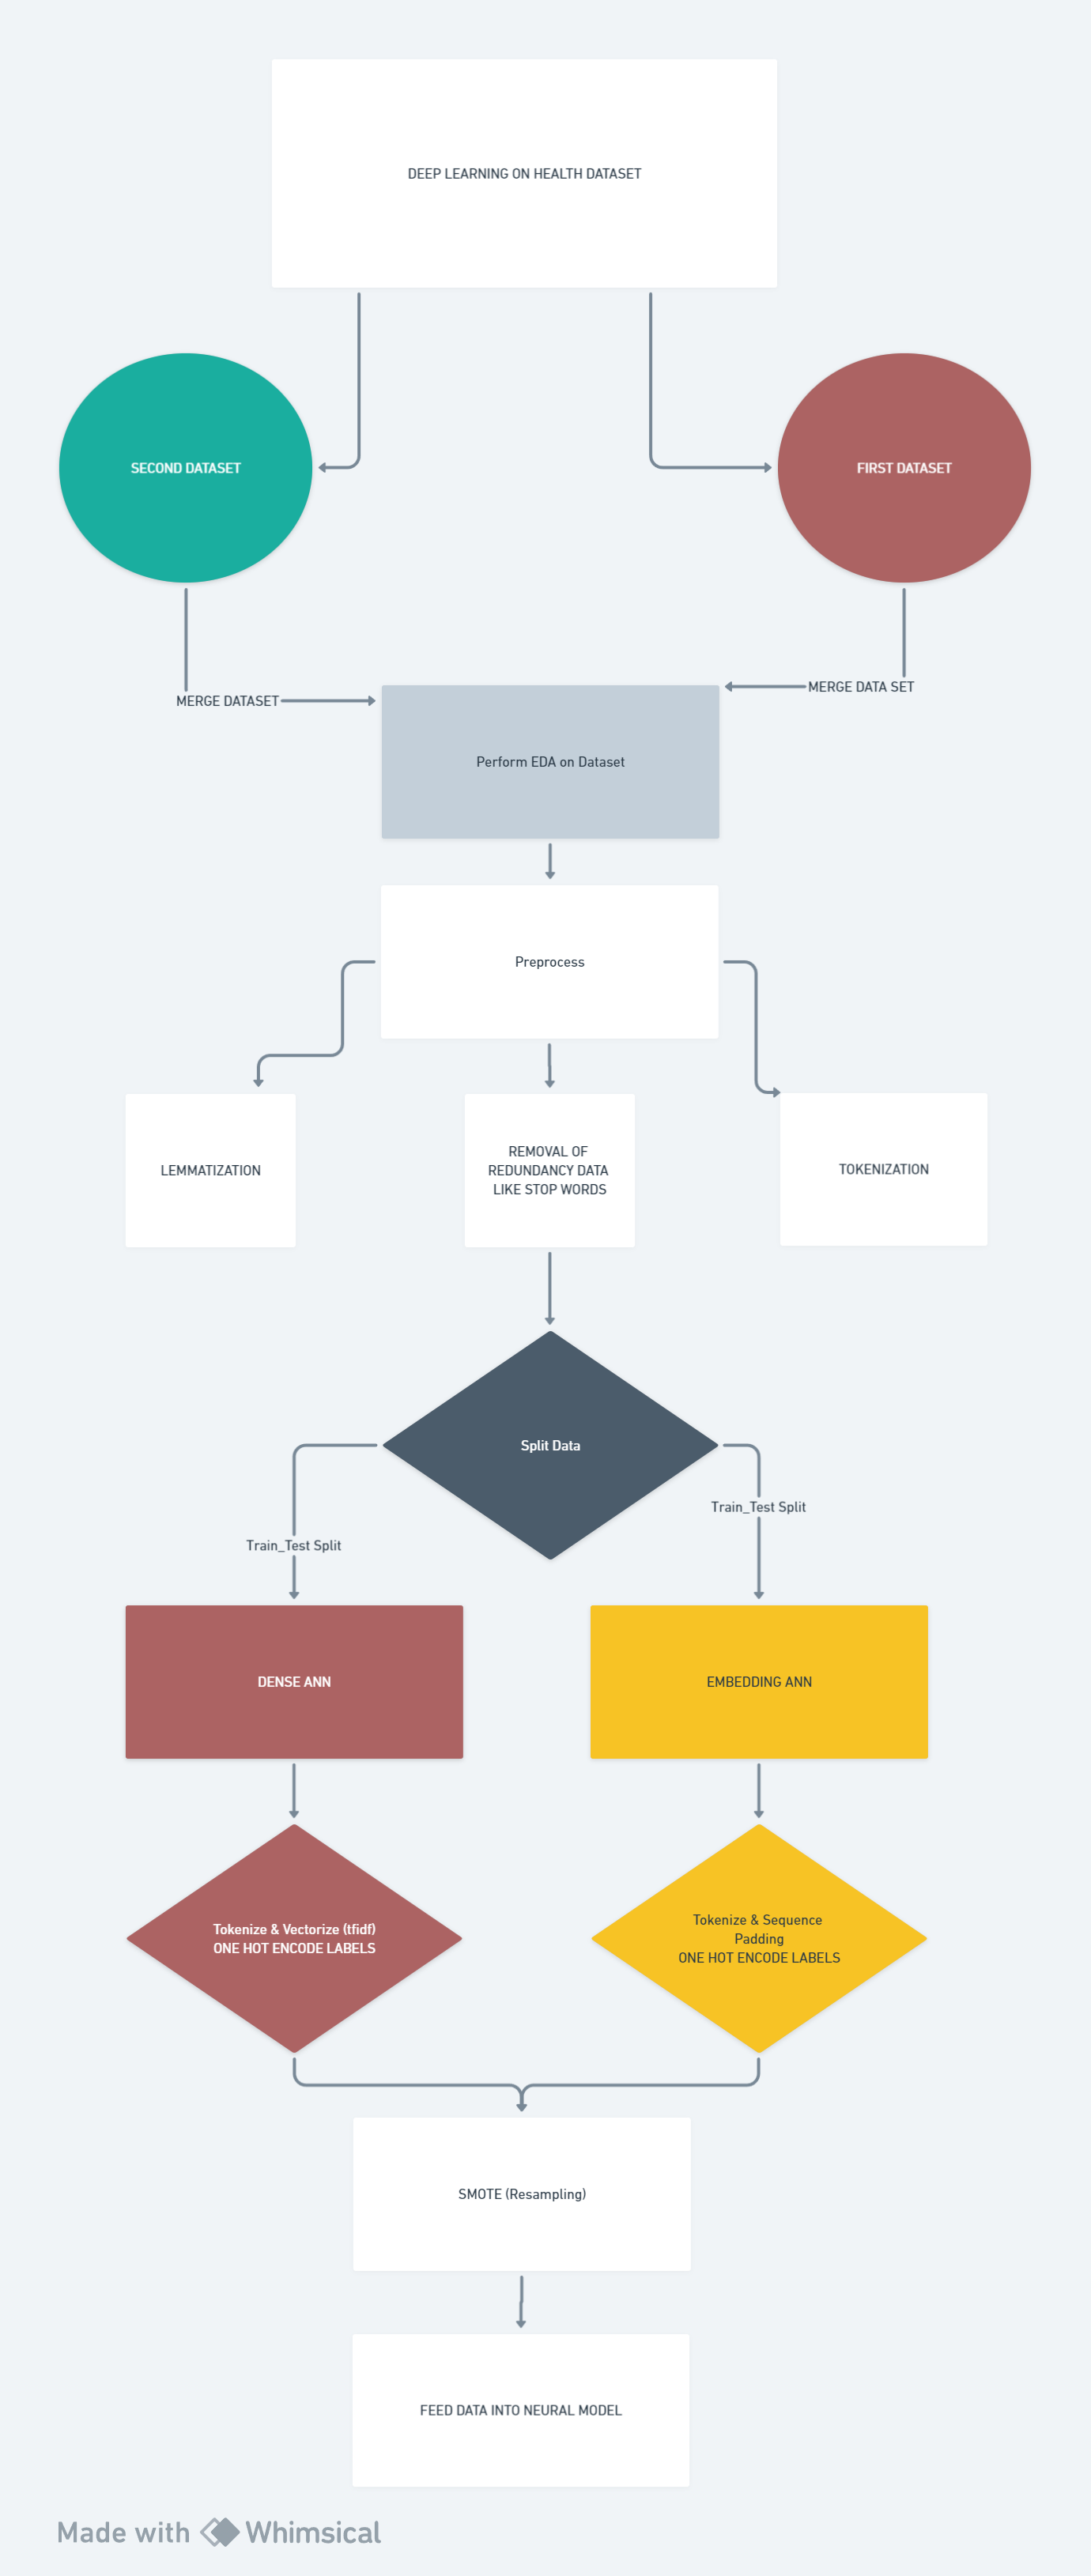

In [62]:
#import two datasets and concatenate them
df_train = pd.read_csv('trainingData/symptom-disease-train-dataset.csv')
df_test = pd.read_csv('trainingData/symptom-disease-test-dataset.csv')

df_combined = pd.concat([df_train, df_test], ignore_index=True)

df = df_combined.sample(frac=1).reset_index(drop=True)
features = df['text']
labels = df['label']
labels.nunique()


1082

## EXPLORATORY DATA ANALYSIS

### Word Cloud Visualization

I will first start by creating a  word cloud to visualize the most common words in the symptom texts. This  will help in providing me with a graphical representation of word frequency. I will generate a word cloud visualization based on the combined symptom texts in my data frame. The plot will display the most common words in the text data, with word size proportional to frequency.



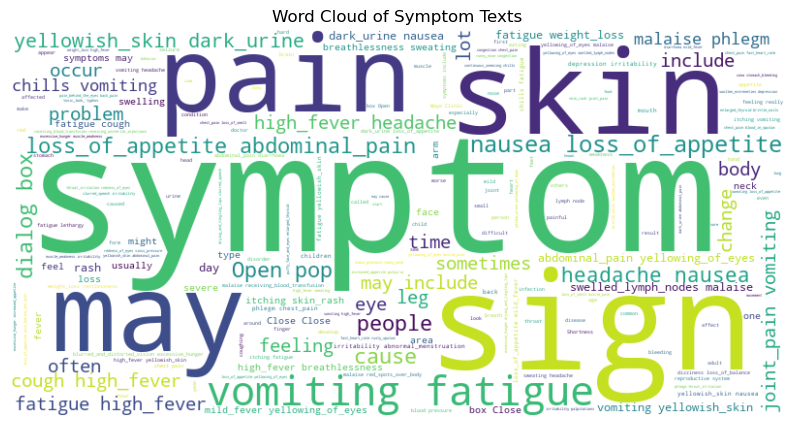

In [63]:
from wordcloud import WordCloud

all_text = ' '.join(df['text'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Symptom Texts')
plt.axis('off')
plt.show()



**Results for cloud visualization:**

After analyzing the word cloud, I've identified several dominant words such as "may," "symptoms," "may include," and "sign," among others. To enhance the effectiveness of model training, I intend to eliminate these dominant words as well as all punctuation marks and English stop words from the dataset, as they are unlikely to contribute significantly to the meaning.


In [64]:
#Check for missing values before preprocessing so i know how to deal with them
missing_symptoms = features.isnull().sum()
missing_labels = labels.isnull().sum()

print("Missing values in symptom column:", missing_symptoms)
print("Missing values in disease column:", missing_labels)


Missing values in symptom column: 0
Missing values in disease column: 0


### Text Length Distribution

I will processed my EDA by Analyzing the distribution of text lengths (symptoms) to understand the range of lengths present in my dataset. This is going to help me determine the appropriate maximum sequence length for tokenization and padding.I will plot the distribution of text lengths to visualize the range of lengths present and the analyze the distribution to understand the typical and extreme lengths.

The standard deviation indicates a wide variation in text lengths, suggesting that padding sequences to a length significantly larger than the mean or median may lead to excessive padding for shorter texts. However, it can ensure that longer texts are not truncated. The maximum text length as shown from the cell below is quite large (2952), and setting the maximum sequence length close to this value may result in excessive memory usage and longer training times. I thought about applying normalization techniques,like the log transformation to reduce the impact of these extreme values or use z-score normalization to scale the lengths to a standard range. But after examining the number of columns with a length greater than 150 (which is 6% of the data), it seems reasonable to sacrifice them to save memory usage and also computational efficiency for normalizing the whole dataset. Therefore, I will choose a padding sequence of 150.

Percenatge of sequences longer than 150: 6.943064035212268


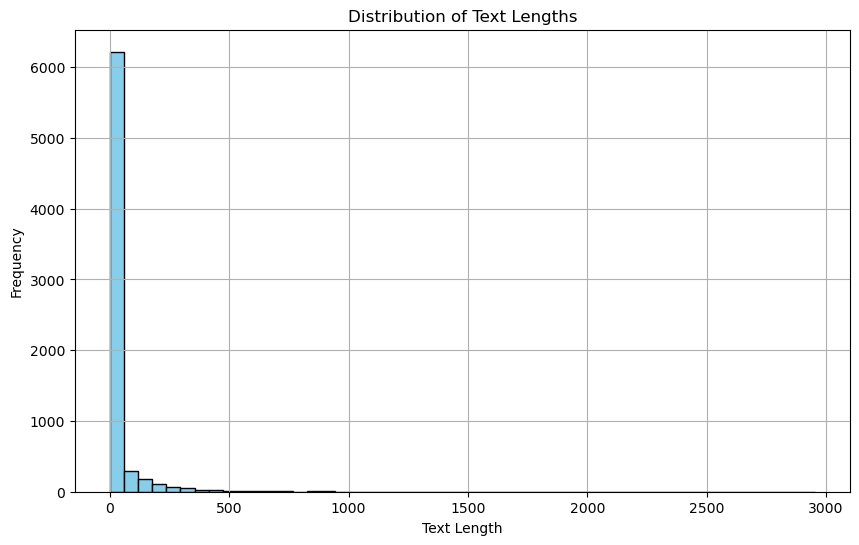

Maximum text length: 2952
Minimum text length: 1
Mean text length: 33.83969899190686
Median text length: 1.0
Standard deviation of text lengths: 109.59128843060937


In [65]:
max_sequence_length = 0
count_long_sequences = 0

# Distribution of the text features
for text in df['text']:
    # Tokenize text to sequences
    sequences = word_tokenize(text)
    # Calculate the length of  sequence
    sequence_length = len(sequences)   
    if sequence_length > 150:
        count_long_sequences += 1
    if sequence_length > max_sequence_length:
        max_sequence_length = sequence_length

print("Percenatge of sequences longer than 150:", (count_long_sequences/len(df))*100)


text_lengths = df['text'].apply(lambda x: len(x.split()))

# Plot the distribution of text lengths
plt.figure(figsize=(10, 6))
plt.hist(text_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#  distribution analysis
print("Maximum text length:", max(text_lengths))
print("Minimum text length:", min(text_lengths))
print("Mean text length:", text_lengths.mean())
print("Median text length:", text_lengths.median())
print("Standard deviation of text lengths:", text_lengths.std())



### CLASS DISTRIBUTION

I will visualise the class distributions to further understand the distribution of the target labels (diseases) to see if they are balanced or imbalanced. As imbalanced classes might require special handling during model training like over or under sampling. . Addressing class imbalances is crucial to ensure that the model learns to generalize well across all classes and doesn't become biased towards predicting the majority class.

Percentage distribution of labels label
596     2.427943
186     2.427943
515     2.427943
1047    2.427943
822     2.427943
          ...   
599     0.014198
400     0.014198
809     0.014198
814     0.014198
584     0.014198
Name: count, Length: 1082, dtype: float64
Imbalance Ratio: 171.0
Percantage of data with counts of 1:  14.72383927303706


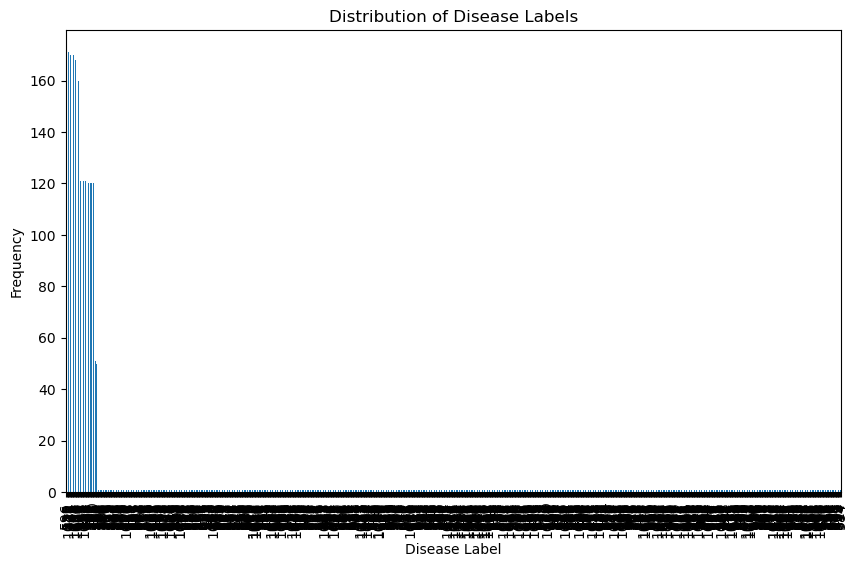

In [66]:
label_counts = labels.value_counts()

#percentage distribution of labels
label_percentage = label_counts / len(df) * 100
print("Percentage distribution of labels",label_percentage)

# The class imbalance ratio
imbalance_ratio = label_counts.max() / label_counts.min()
print("Imbalance Ratio:", imbalance_ratio)

import matplotlib.pyplot as plt

# Count the frequency of each label
label_counts = df['label'].value_counts()

# Plot label Distribution
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.xlabel('Disease Label')
plt.ylabel('Frequency')
plt.title('Distribution of Disease Labels')
#plt.show()

labels_to_remove = label_counts[label_counts == 1].index
length_of_ltr= len(labels_to_remove)
percetage_ltr= (length_of_ltr/len(df))*100
print("Percantage of data with counts of 1: ",percetage_ltr)




**Observation Results**

From the results below, we can see that the data has an imbalance ratio of 171 which is very high and indicates a great imbalance in the dataset.I observed a prevalence of classes with a count of 1, contributing to the high imbalance ratio among the classes. Initially, I contemplated removing labels with a count of 1 to address the imbalance, however this would entail sacrificing 14% of my already limited data sample. Given the small size of the dataset, such a reduction would compromise the robustness of the model during training.

Faced with the need for alternatives, I considered resampling or class weighing. Resampling emerged as the preferred choice due to its ability to augment the dataset without discarding valuable information. Unlike class weighting or specialized loss functions, resampling directly addresses the scarcity of data in minority classes by either oversampling or undersampling techniques.

Among the oversampling methods, I opted for SMOTE (Synthetic Minority Over-sampling Technique) over Random Oversampling. SMOTE generates synthetic samples by interpolating between existing minority class instances, thereby enhancing the diversity of the dataset. This approach is advantageous as it introduces new data points that closely resemble the existing minority class instances, promoting better generalization of the model without simply duplicating existing samples.

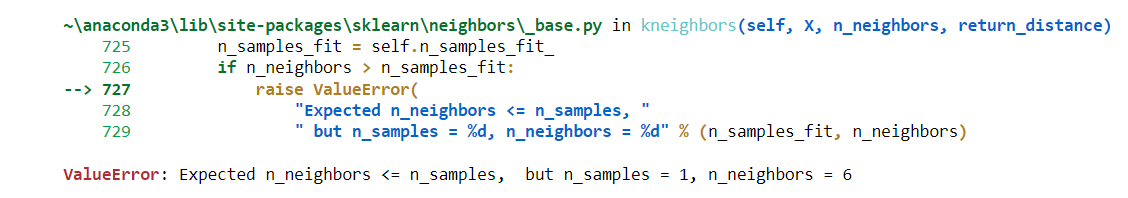
My attempts not to discard the data samples with a value count of 1 resulted in the error above, i even tried using different different variant of SMOTE, such as KNeighborsSMOTE and SMOTETomek but the value counts had to be greater than 6. So i had no choice than to discard the samples, which seemed like the second best option to sampling. I then plan to use the discarded samples as testing data to test my model to see how well it generalizes to unseen data.

### PREPROCESS THE TEXT USING INSIGHTS FROM THE EDA

1. **Tokenize the text**
2. **Remove dominant words, punctuation and stop words**
3. **Lemmatize**


In [67]:

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    '''
    Preprocesses the input text by tokenizing, removing stopwords, punctuation, and lemmatizing the words.

    Arguments:
    - text (str): The input text to be preprocessed.

    Returns:
    str: The preprocessed text after tokenization, removal of stopwords, punctuation, and lemmatization.
    '''
  
    tokens = word_tokenize(text)
    
    # Remove punctuation
    tokens = [word for word in tokens if word not in string.punctuation]
    
    # Remove dominant words
    dominant_words = ["may", "symptoms", "may include", "sign", "also"]
    tokens = [word for word in tokens if word.lower() not in dominant_words]
    
    # Remove English stopwords
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    
    # Lemmatize the words
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    preprocessed_text = ' '.join(lemmatized_tokens)
    
    return preprocessed_text



In [ ]:
#Remove samples with a value count of 1
label_counts = df['label'].value_counts()
labels_to_remove = label_counts[label_counts == 1].index
df_filtered = df[~df['label'].isin(labels_to_remove)].copy()  

#preprocess the filtered data
df_filtered['cleaned_text'] = df_filtered['text'].apply(preprocess_text)

df_filtered = df_filtered.drop(columns=['text'])

labels = df_filtered['label']
features = df_filtered['cleaned_text']
print("Preprocessed features:", features[3:9])
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Dense Layer Data Preprocessing
tokenizer_dense = keras.preprocessing.text.Tokenizer()
# apply only to X_train to prevent data leakage from the testing or validation data into the model
tokenizer_dense.fit_on_texts(X_train)
vocab_size_dense = len(tokenizer_dense.word_index) + 1

print("Vocabulary size (Dense):", vocab_size_dense)
X_train_dense1 = tokenizer_dense.texts_to_matrix(X_train, mode='tfidf')  
X_test_dense = tokenizer_dense.texts_to_matrix(X_test, mode='tfidf')  

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

encoder = OneHotEncoder(sparse=False)
y_train = encoder.fit_transform(y_train_encoded.reshape(-1, 1))
y_test = encoder.transform(y_test_encoded.reshape(-1, 1))

num_classes = len(label_encoder.classes_)
print('Number of classes:', num_classes)

# Embedding Layer Data Preprocessing
max_words = 15000
tokenizer_embedding = keras.preprocessing.text.Tokenizer(num_words=max_words)
tokenizer_embedding.fit_on_texts(X_train)
vocab_size_embedding = len(tokenizer_embedding.word_index) + 1
print("Vocabulary size (Embedding):", vocab_size_embedding)

sequences_train = tokenizer_embedding.texts_to_sequences(X_train)
sequences_test = tokenizer_embedding.texts_to_sequences(X_test)

max_len = 150
X_train_emb1 = keras.preprocessing.sequence.pad_sequences(sequences_train, maxlen=max_len, padding='post')
X_test_emb = keras.preprocessing.sequence.pad_sequences(sequences_test, maxlen=max_len, padding='post')

smote = SMOTE(random_state=42)

X_train_emb, y_train_emb = smote.fit_resample(X_train_emb1, y_train)
X_train_dense, y_train_dense = smote.fit_resample(X_train_dense1, y_train)

print("Shapes after splitting:")
print("X_train_emb_resampled.shape:", X_train_emb.shape)
print("X_test_emb.shape:", X_test_emb.shape)
print("y_train_dnse resampled.shape:", y_train_dense.shape)
print("y_test_emb.shape:", y_test.shape)
print("X_train_dense_resampled.shape:", X_train_dense.shape)
print("X_test_dense.shape:", X_test_dense.shape)
print("y_train_emb_resampled.shape:", y_train_emb.shape)
print("y_test_dense.shape:", y_test.shape)

#PARTITION THE DATA FOR TAINING AND VALIDATION FOR DENSE LAYER
X_partial_train, X_validation, y_partial_train, y_validation = train_test_split(X_train_dense, y_train_dense, test_size=0.2, random_state=42)


#PARTITION THE DATA FOR TAINING AND VALIDATION FOR EMBEDDING LAYER
X_partial_train_emb, X_validation_emb, y_partial_train_emb, y_validation_emb = train_test_split(X_train_emb, y_train_emb, test_size=0.2, random_state=42)


### Verfying that the classes are balanced

Class Distribution: [144 144 144 144 144 144 144 144 144 144 144 144 144 144 144 144 144 144
 144 144 144 144 144 144 144 144 144 144 144 144 144 144 144 144 144 144
 144 144 144 144 144 144 144 144 144]


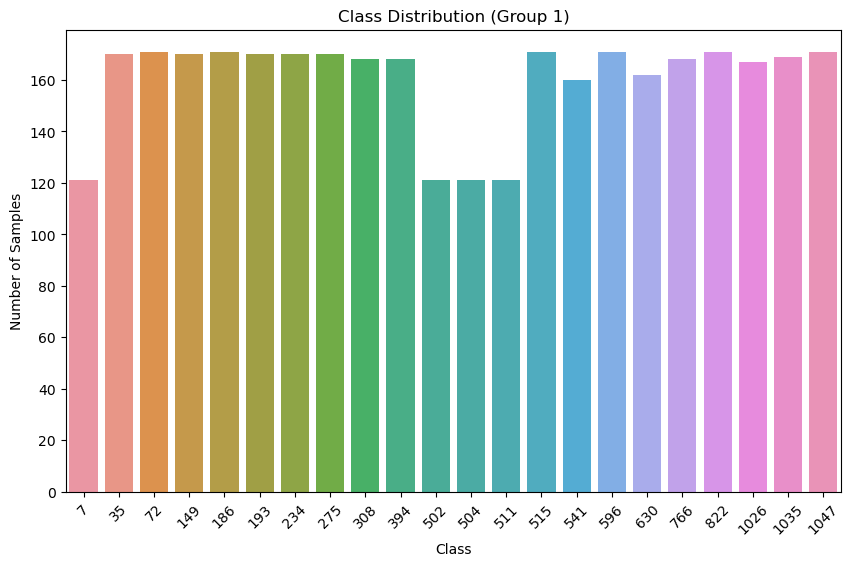

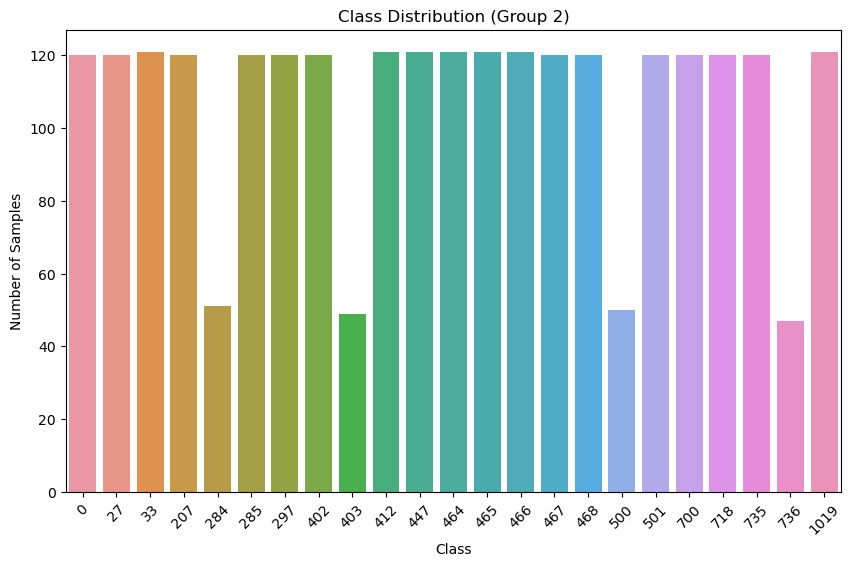

In [69]:

class_distribution = np.sum(y_train_emb, axis=0)  
total_samples = np.sum(class_distribution)  

#  proportion of each class
class_proportion = class_distribution / total_samples

print("Class Distribution:", class_distribution)


labels = df_filtered['label']

class_counts = labels.value_counts()

group1 = class_counts[:len(class_counts)//2]
group2 = class_counts[len(class_counts)//2:]

plt.figure(figsize=(10, 6))
sns.barplot(x=group1.index, y=group1.values)
plt.title('Class Distribution (Group 1)')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=group2.index, y=group2.values)
plt.title('Class Distribution (Group 2)')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()


# BASELINE MODEL

So for my baselime model, i am starting with something simple, just an input layer, with 64 neurons and a hidden layer with softmax activation function since its a multi classification problem.I  randomly initialised the parameters  I am also using a simple gradient descent to update my weights after backpropagation and i am using categorical cross entropy loss function to determine my model's accuracy.

In [16]:
class NeuralNetwork:
    def __init__(self):
        pass
    
    def init_params(self, input_size, hidden_size1, output_size):
        """
            Randomly Initialize parameters(weights and biases) for a neural network.

            Arguments:
            - input_size: Integer, the size of the input features.
            - hidden_size1: Integer, the number of neurons in the first hidden layer.
            - output_size: Integer, the number of neurons in the output layer.

            Returns:
            - parameters: Dictionary, containing the initialized weights and biases for each layer of the neural network.
              - "W": are weights where "b" are biases
        """
        np.random.seed(0)
        W1 = np.random.randn(hidden_size1, input_size) * 0.01
        b1 = np.zeros((hidden_size1, 1))
        W3 = np.random.randn(output_size, hidden_size1) * 0.01
        b3 = np.zeros((output_size, 1))
        parameters = {"W1": W1, "b1": b1, "W3": W3, "b3": b3}
        return parameters

    def forward_propagation(self, X, parameters):
        """
        Performs forward propagation through the neural network.

        Parameters:
        - X : Input data of shape (input_size, num_samples).
        - parameters (dict): Dictionary containing the weights and biases of the neural network.

        Returns:
        - A3 (numpy.ndarray): Output predictions of shape (output_size, num_samples).
        - cache (dict): Dictionary containing the intermediate values required for backpropagation.
        """

        
        W1, b1, W3, b3 = parameters["W1"], parameters["b1"], parameters["W3"], parameters["b3"]

        # Input layer
        Z1 = np.dot(W1, X.T) + b1  # preactivation layer
        A1 = self.ReLU(Z1)
        # Output layer
        Z3 = np.dot(W3, A1) + b3
        A3 = self.softmax(Z3)
        cache = {"Z1": Z1, "A1": A1, "Z3": Z3, "A3": A3}
        return A3, cache

    def backward_propagation(self, parameters, cache, X, Y):
        """
        Perform backward propagation through the neural network.

        Parameters:
        - parameters (dict): Dictionary containing the weights and biases of the neural network.
        - cache (dict): Dictionary containing the intermediate values from the forward pass.
        - X (numpy.ndarray): Input data of shape (input_size, num_samples).
        - Y (numpy.ndarray): True labels of shape (output_size, num_samples).

        Returns:
        - gradients (dict): Dictionary containing the gradients of the parameters.
        """

        m = X.shape[1]  # number of samples
        W1, b1, W3, b3 = parameters["W1"], parameters["b1"], parameters["W3"], parameters["b3"]

        # Retrieve cached values
        A1, A3, Z1 = cache["A1"], cache["A3"], cache["Z1"]

        # Compute gradients
        dZ3 = A3 - Y.T  
        dW3 = (1 / m) * np.dot(dZ3, A1.T)
        db3 = (1 / m) * np.sum(dZ3, axis=1, keepdims=True)

        dA1 = np.dot(W3.T, dZ3)
        dZ1 = np.array(dA1, copy=True)
        dZ1[Z1 <= 0] = 0  # derivative of ReLU activation
        dW1 = 1 / m * np.dot(dZ1, X)
        db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)

        gradients = {"dW1": dW1, "db1": db1, "dW3": dW3, "db3": db3}

        return gradients

    def update_parameters(self, parameters, gradients, learning_rate=0.001):
        """
        Update the parameters of the neural network using gradient descent.

        Parameters:
        - parameters (dict): Dictionary containing the weights and biases of the neural network.
        - gradients (dict): Dictionary containing the gradients of the parameters.
        - learning_rate (float): Learning rate for gradient descent (default: 0.001).

        Returns:
        - updated_parameters (dict): Dictionary containing the updated weights and biases.
        """

        updated_parameters = {}
        for key in parameters:
            updated_parameters[key] = parameters[key] - learning_rate * gradients["d" + key]
        return updated_parameters

  
    def model_predict(self, X, parameters):
        """
        Make predictions using the trained neural network.

        Parameters:
        - X (numpy.ndarray): Input data of shape (num_samples, input_size).
        - parameters (dict): Dictionary containing the trained weights and biases.

        Returns:
        - predictions (numpy.ndarray): Predicted probabilities of shape (num_samples, output_size).
        """
        A2, _ = self.forward_propagation(X, parameters)
        predictions = A2.T
        return predictions

    def compute_accuracy(self, y_true, y_pred):
        """
        Compute the accuracy of the predicted labels.

        Parameters:
        - y_true (numpy.ndarray): True labels of shape (num_samples, output_size).
        - y_pred (numpy.ndarray): Predicted probabilities of shape (num_samples, output_size).

        Returns:
        - acc (float): Accuracy value.
        """
        # Converting predicted probabilities to class labels
        y_pred_labels = np.argmax(y_pred, axis=1)

        # Converting true labels from one-hot encoding to class labels
        y_true_labels = np.argmax(y_true, axis=1)

        # Computing accuracy
        correct_predictions = np.sum(y_pred_labels == y_true_labels)
        total_samples = y_true.shape[0]
        acc = correct_predictions / total_samples
        return acc

    def compute_recall(self, y_true, y_pred):
        """
        Compute recall for the multi-class classification problem.

        Arguments:
        y_true -- True labels in one-hot encoding format, shape (num_samples, num_classes)
        y_pred -- Predicted probabilities for each class, shape (num_samples, num_classes)

        Returns:
        recall -- Recall score for each class, shape (num_classes,)
        """
        # Converting predicted probabilities to class labels
        y_pred_labels = np.argmax(y_pred, axis=1)

        # Converting true labels from one-hot encoding to class labels
        y_true_labels = np.argmax(y_true, axis=1)

        # Initialize variables to store recall for each class
        num_classes = y_true.shape[1]
        recall = np.zeros(num_classes)

        # Compute recall for each class
        for c in range(num_classes):
            true_positive = np.sum((y_true_labels == c) & (y_pred_labels == c))
            actual_positive = np.sum(y_true_labels == c)

            # Handle division by zero
            if actual_positive == 0:
                recall[c] = 0
            else:
                recall[c] = true_positive / actual_positive

        return recall
    
    def compute_recall_weighted(self,y_true, y_pred):
        """
        Compute the weighted recall score.

        Parameters:
        - y_true (numpy.ndarray): True labels of shape (num_samples, num_classes).
        - y_pred (numpy.ndarray): Predicted probabilities of shape (num_samples, num_classes).

        Returns:
        - weighted_recall (float): Weighted recall score.
        """

        y_true_labels = np.argmax(y_true, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)

        # Compute the weighted recall score
        weighted_recall = recall_score(y_true_labels, y_pred_labels, average='weighted',zero_division=1)

        return weighted_recall
    
    def categorical_cross_entropy_loss(self, A3, Y):
        """
        Arguments:
        A3 --  predicted probabilities of a sample belonging to each class
        Y -- true "label" vector,one hot encoded 
        Returns:
        loss -- Scalar value representing the categorical cross-entropy loss
        """

        m = Y.shape[0]  # Number of samples
        epsilon = 1e-15  # Small value to avoid taking the logarithm of zero

        A_clipped = np.clip(A3, epsilon, 1 - epsilon)
        Y = Y.T
        loss = -(1 / m) * np.sum(Y * np.log(A_clipped))

        return loss

    def ReLU(self, Z):
        """
        Compute the Rectified Linear Unit (ReLU) activation function.

        Parameters:
        - Z (numpy.ndarray): Input values.

        Returns:
        - A (numpy.ndarray): Output of the ReLU activation function.
        """
        return np.maximum(0, Z)

    def softmax(self, Z):
        """
        Compute the softmax activation function.

        Parameters:
        - Z (numpy.ndarray): Input values.

        Returns:
        - A (numpy.ndarray): Output of the softmax activation function.
        """
        exp_Z = np.exp(Z - np.max(Z, axis=0))  
        return exp_Z / (np.sum(exp_Z, axis=0) + 1e-15)

    def tanh(self, Z):
        """
        Compute the hyperbolic tangent (tanh) activation function.

        Parameters:
        - Z (numpy.ndarray): Input values.

        Returns:
        - A (numpy.ndarray): Output of the tanh activation function.
        """
        return np.tanh(Z)
    
    
    
    def train_neural_network(self, X, Y, input_size, hidden_size1, output_size, learning_rate, num_epochs,print_loss=True):
        """
        Train the neural network using gradient descent.

        Parameters:
        - X (numpy.ndarray): Input data of shape (num_samples, input_size).
        - Y (numpy.ndarray): True labels of shape (num_samples, output_size).
        - input_size (int): Number of features in the input data.
        - hidden_size1 (int): Number of units in the first hidden layer.
        - output_size (int): Number of output classes.
        - learning_rate (float): Learning rate for gradient descent.
        - num_epochs (int): Number of training epochs.
        - print_loss (bool): Whether to print the loss during training (default: True).

        Returns:
        - parameters (dict): Dictionary containing the trained weights and biases.
        - losses (list): List of loss values during training.
        - train_accuracies (list): List of training accuracies during training.
        - recalls (list): List of training recalls during training.
        """
        # Initialize parameters
        parameters = self.init_params(input_size, hidden_size1, output_size)

        losses = []
        train_accuracies = []
        recalls = []

        for epoch in range(1, num_epochs + 1):
            # Forward propagation
            A3, cache = self.forward_propagation(X, parameters)
            loss = self.categorical_cross_entropy_loss(A3, Y)
            predictions = self.model_predict(X, parameters)
            train_accuracy = self.compute_accuracy(predictions, Y)
            train_recall = self.compute_recall(predictions, Y)
            # Backward propagation
            gradients = self.backward_propagation(parameters, cache, X, Y)

            # Update parameters using update_params

            parameters = self.update_parameters(parameters, gradients, learning_rate)

            if print_loss and epoch % 10 == 0:
                print(f"Loss: {loss} Training Accuracy:  {train_accuracy}  after epoch {epoch}")

            losses.append(loss)
            train_accuracies.append(train_accuracy)
            recalls.append(train_recall)

        return parameters, losses, train_accuracies, recalls

    
    
    def plot_learning(self, data, ylabel):
        """
        Plot the learning curve.

        Parameters:
        - data (list or numpy.ndarray): Data to plot.
        - ylabel (str): Label for the y-axis.
        """
        plt.plot(data)
        plt.xlabel('Epochs')
        plt.ylabel(ylabel)
        plt.title('Training Performance: ' + ylabel)
        plt.show()

    def plot_learning_val(self, train_data, val_data, ylabel):
        """
        Plot the learning curves for training and validation data.

        Parameters:
        - train_data (list): List of training data for each epoch.
        - val_data (list): List of validation data for each epoch.
        - ylabel (str): Label for the y-axis.
        """
        min_length = min(len(inner) for inner in train_data + val_data)

        average_train_history = [np.mean([x[i] for x in train_data]) for i in range(min_length)]
        average_val_history = [np.mean([x[i] for x in val_data]) for i in range(min_length)]

        epochs = range(1, min_length + 1)

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, average_train_history, label="Training")
        plt.plot(epochs, average_val_history, label="Validation")
        plt.xlabel('Epochs')
        plt.ylabel(ylabel)
        plt.title('Training and Validation Performance: ' + ylabel)
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs[-10:], average_train_history[-10:], label="Training")
        plt.plot(epochs[-10:], average_val_history[-10:], label="Validation")
        plt.xlabel('Epochs')
        plt.ylabel(ylabel)
        plt.title('Last 10 Epochs Performance: ' + ylabel)
        plt.legend()

        plt.tight_layout()
        plt.show()

    def evaluate_model_performance(self, X_test, y_test, trained_parameters):
        """
        Evaluate the performance of the trained model on the test data.

        Parameters:
        - X_test (numpy.ndarray): Test input data.
        - y_test (numpy.ndarray): True labels for the test data.
        - trained_parameters (dict): Trained parameters of the model.
        """
        # Get predictions from the model
        prediction_test = self.model_predict(X_test, trained_parameters)

        # Compute accuracy, loss, and recall
        test_accuracy = self.compute_accuracy(prediction_test, y_test)
        test_loss = self.categorical_cross_entropy_loss(prediction_test, y_test.T)
        test_recall = self.compute_recall_weighted(prediction_test, y_test)

        print(f"Model test predictions gave an Accuracy of : {test_accuracy} and Recall of : {test_recall} and a Loss of : {test_loss}")

        # Convert predicted probabilities to class labels
        y_pred_labels = np.argmax(prediction_test, axis=1)

        # Convert true labels from one-hot encoding to class labels
        y_true_labels = np.argmax(y_test, axis=1)

        # Compute metrics using scikit-learn functions
        test_acc = accuracy_score(y_pred_labels, y_true_labels)
        test_precision = precision_score(y_pred_labels, y_true_labels, average='weighted')
        test_recall = recall_score(y_pred_labels, y_true_labels, average="weighted")

        print("Test accuracy with libraries:", test_acc, "Recall score:", test_recall, "Precision for the test:", test_precision)


Loss: 3.7994031192667506 Training Accuracy:  0.20162509448223734  after epoch 10
Loss: 3.791249138727712 Training Accuracy:  0.4246031746031746  after epoch 20
Loss: 3.7808790416703486 Training Accuracy:  0.5266439909297053  after epoch 30
Loss: 3.7666822798749817 Training Accuracy:  0.5808767951625095  after epoch 40
Loss: 3.746327808273406 Training Accuracy:  0.5523431594860166  after epoch 50
Loss: 3.7164319907185774 Training Accuracy:  0.531557067271353  after epoch 60
Loss: 3.6721596620838257 Training Accuracy:  0.4512471655328798  after epoch 70
Loss: 3.607345705576162 Training Accuracy:  0.4255479969765684  after epoch 80
Loss: 3.5170226515752048 Training Accuracy:  0.39777021919879063  after epoch 90
Loss: 3.4028838686730762 Training Accuracy:  0.36904761904761907  after epoch 100


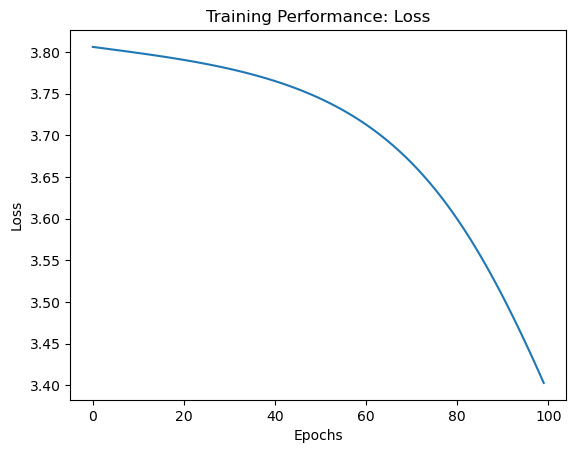

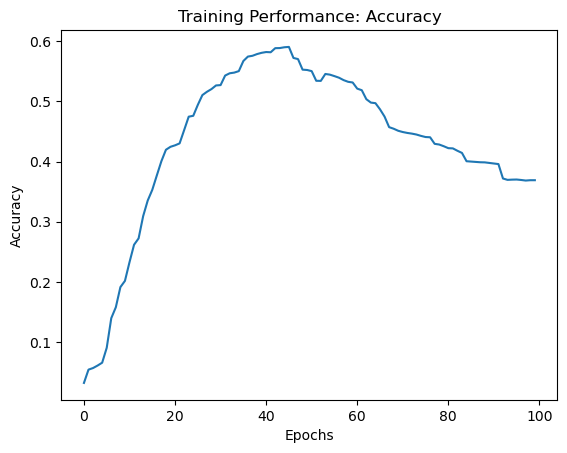

Model test predictions gave an Accuracy of : 0.3544973544973545 and Recall of : 0.3544973544973545 and a Loss of : 100.2718690651774
Test accuracy with libraries: 0.3544973544973545 Recall score: 0.3544973544973545 Precision for the test: 0.9337223956859505


C:\Users\patty\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
#TRAINING 
neural_network = NeuralNetwork()
trained_parameters_baseline, losses_baseline ,accuracies_baseline, recalls_baseline= neural_network.train_neural_network(X_partial_train, y_partial_train, input_size=vocab_size_dense, hidden_size1=64, output_size=num_classes, num_epochs=100, learning_rate=0.02, print_loss=True)

neural_network.plot_learning(losses_baseline,'Loss')
neural_network.plot_learning(accuracies_baseline, 'Accuracy')

#EVALUATION
neural_network.evaluate_model_performance(X_validation, y_validation, trained_parameters_baseline)

# EXPERIMENT 1

In an attempt to improve my baseline perfomance, building upon the foundation of my existing architecture, i created a more deeper neural network in an attempt to beat the baseline accuarcy of 35.4% , recall of 35.4% and a loss of 100. This architecture consist of three layers: an input layer employing Rectified Linear Unit (ReLU) activation with **128 neurons**, a hidden layer utilizing hyperbolic tangent **(tanh) activation with 64 neurons**, and an output layer employing softmax activation with 45 neurons corresponding to the unique number of classes in the dataset.I also increased the number of iterations from 100 to **200** becaused I noticed the erratic behavior of the accuracy, oscillating back and forth like a pendulum and by extending the training duration, the aim was to ensure that the model had sufficient time to converge to the global minimum of the loss function, thereby mitigating the risk of settling for a suboptimal solution characterized by local minima.I also used a different and more complex optimizer function , **adam** from the basic gradient descent because of its ability for adaptive learning rates and dynamic adjustments, i believe this will help to steer my model towards faster convergence and, hopefully, superior performance.

In [70]:
class ModifiedNeuralNetwork(NeuralNetwork):
    def __init__(self):
        super().__init__()  # the parent class

    def init_params(self, input_size, hidden_size1, hidden_size2, output_size):
        """
        Initialize parameters for a neural network.

        Arguments:
        - input_size: Integer, the size of the input features.
        - hidden_size1: Integer, the number of neurons in the first hidden layer.
        - hidden_size2: Integer, the number of neurons in the second hidden layer.
        - output_size: Integer, the number of neurons in the output layer.

        Returns:
        - parameters: Dictionary, containing the initialized weights and biases for each layer of the neural network.
          - "W": are weights where "b" are biases
        """
        np.random.seed(0)
        W1 = np.random.randn(hidden_size1, input_size) * 0.01
        b1 = np.zeros((hidden_size1, 1))
        W2 = np.random.randn(hidden_size2, hidden_size1) * 0.01
        b2 = np.zeros((hidden_size2, 1))
        W3 = np.random.randn(output_size, hidden_size2) * 0.01
        b3 = np.zeros((output_size, 1))
        parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3}
        return parameters

    def categorical_cross_entropy_loss(self, A3, Y):
        """
        Arguments:
        A3 -- predicted probabilities of a sample belonging to each class
        Y -- true "label" vector, one hot encoded
        Returns:
        loss -- Scalar value representing the categorical cross-entropy loss
        """
        m = Y.shape[0]  # Number of samples
        epsilon = 1e-15  # Smal value to avoid taking the logarithm of zero
        #we clip tom prevent compuational stability during log calcluation
        A_clipped = np.clip(A3, epsilon, 1 - epsilon)
        Y = Y.T
        loss = -(1 / m) * np.sum(Y * np.log(A_clipped))
        return loss

    def forward_propagation(self, X, parameters):
        """
        Perform forward propagation through the neural network.

        Arguments:
        - X: input data.
        - parameters: Dictionary, containing the weights and biases for each layer of the neural network from init_params function

        Returns:
        - A3: Array, shape (num_classes, num_samples), output probabilities for each class.
        - cache: Dictionary, with arrays of shape(layer_size, num_samples)
          - "Z1": preactivation values for the input layer.
          - "A1": activated values for the input layer.
          - "Z2": preactivation values for the 2nd hidden layer.
          - "A2": activation values for the 2nd hidden layer.
          - "Z3": preactivation values for the output layer.
          - "A3": output probabilities for each class.
        """
        W1, b1, W2, b2, W3, b3 = parameters["W1"], parameters["b1"], parameters["W2"], parameters["b2"], parameters[
            "W3"], parameters["b3"]

        # Input layer
        Z1 = np.dot(W1, X.T) + b1  # preactivation layer
        A1 = self.ReLU(Z1)
        # Hidden layer
        Z2 = np.dot(W2, A1) + b2
        A2 = self.tanh(Z2)
        # Output layer
        Z3 = np.dot(W3, A2) + b3
        A3 = self.softmax(Z3)
        cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2, "Z3": Z3, "A3": A3}
        return A3, cache

    def backward_propagation(self, parameters, cache, X, Y):
        """
        Compute the gradients of the loss with respect to the parameters using backpropagation.

        Arguments:
        X -- Input data, shape (input_size, num_samples)
        Y -- True labels, shape (output_size, num_samples)
        cache -- Dictionary containing the intermediate values from forward propagation
        parameters -- Dictionary containing the model's parameters
        Returns:
        gradients -- Dictionary containing the gradients of the loss with respect to each parameter
        """
        m = X.shape[1]  # number of samples in the batch
        W1, b1, W2, b2, W3, b3 = parameters["W1"], parameters["b1"], parameters["W2"], parameters["b2"], parameters[
            "W3"], parameters["b3"]

        # Retrieve cached values
        A1, A2, A3 = cache["A1"], cache["A2"], cache["A3"]
        Z1, Z2, Z3 = cache["Z1"], cache["Z2"], cache["Z3"]

        # Computing gradients
        dZ3 = A3 - Y.T  #derivative of softamx(error signals for each class)
        dW3 = 1 / m * np.dot(dZ3, A2.T)
        db3 = 1 / m * np.sum(dZ3, axis=1, keepdims=True)

        dA2 = np.dot(W3.T, dZ3)
        dZ2 = dA2 * (1 - np.power(A2, 2))  # derivative of tanh activation(1-tanh**2(z))
        dW2 = 1 / m * np.dot(dZ2, A1.T)
        db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)

        dA1 = np.dot(W2.T, dZ2)
        dZ1 = np.array(dA1, copy=True)
        dZ1[Z1 <= 0] = 0  # derivative of ReLU activation
        dW1 = 1 / m * np.dot(dZ1, X)
        db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)

        gradients = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2, "dW3": dW3, "db3": db3}

        return gradients

    def update_parameters(self, parameters, gradients, v, s, t, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-15):
        """
         optimization algorithm to update the parameters of the neural network by combining momentum 
          and RMSprop techniques to achieve faster and more stable convergence during training.
        Arguments:
        parameters -- Dictionary containing the model's parameters
        gradients -- Dictionary containing the gradients of the loss with respect to each parameter
        v -- Dictionary containing the exponentially weighted average of the gradients
        s -- Dictionary containing the exponentially weighted average of the squared gradients
        t -- Current timestep (iteration)
        learning_rate -- Learning rate for the update
        beta1 -- Exponential decay rate for the first moment estimate
        beta2 -- Exponential decay rate for the second moment estimate
        epsilon -- Small value to avoid division by 0

        Returns:
        parameters -- Updated parameters
        v -- Updated exponentially weighted average of the gradients
        s -- Updated exponentially weighted avg of the squared gradients
        """
        for param_name in parameters.keys():
            # Update biased 1st moment estimate
            v[param_name] = beta1 * v[param_name] + (1 - beta1) * gradients["d" + param_name]
            s[param_name] = beta2 * s[param_name] + (1 - beta2) * np.square(gradients["d" + param_name])
            #Correcting Bias in Moment Estimates:
            v_corrected = v[param_name] / (1 - beta1**t)
            s_corrected = s[param_name] / (1 - beta2**t)
             #Updating Parameters:
            parameters[param_name] -= learning_rate * v_corrected / (np.sqrt(s_corrected) + epsilon)

        return parameters, v, s

    def train_neural_network(self, X, Y, input_size, hidden_size1, hidden_size2, output_size, learning_rate, num_epochs, print_loss=True):
        parameters = self.init_params(input_size, hidden_size1, hidden_size2, output_size)
        """
        Train a neural network model using stochastic gradient descent with Adam optimizer.
        Arguments:
        X -- Input data of shape (num_samples, input_size)
        Y -- True labels of shape (num_samples, output_size)
        input_size -- Number of features in the input data
        hidden_size1 -- Number of neurons in the first hidden layer(128)
        hidden_size2 -- Number of neurons in the second hidden layer(64)
        output_size -- Number of output classes(45)
        learning_rate -- Learning rate for gradient descent
        num_epochs -- Number of training epochs
        print_loss -- Boolean  to print the loss during training (default is True)

        Returns:
        parameters -- Trained parameters of the neural network
        losses -- List of loss values at each epoch during training
        """

        # Initialize variables for optimizer
        v = {key: np.zeros_like(value) for key, value in parameters.items()}
        s = {key: np.zeros_like(value) for key, value in parameters.items()}
        t = 0

        losses = []
        accuracies = []
        recalls = []

        for epoch in range(1, num_epochs + 1):
            A3, cache = self.forward_propagation(X, parameters)
            loss = self.categorical_cross_entropy_loss(A3, Y)
            predictions = self.model_predict(X, parameters)
            train_accuracy = self.compute_accuracy(predictions, Y)
            train_recall = self.compute_recall(predictions, Y)
            gradients = self.backward_propagation(parameters, cache, X, Y)
            t += 1
            parameters, v, s = self.update_parameters(parameters, gradients, v, s, t, learning_rate)

            if print_loss and epoch % 20 == 0:
                print(f"Loss : {loss}  Accuracy: {train_accuracy} after epoch {epoch}")

            losses.append(loss)
            accuracies.append(train_accuracy)
            recalls.append(train_recall)

        return parameters, losses, accuracies, recalls


Loss : 0.002981290036821916  Accuracy: 1.0 after epoch 20
Loss : 0.0002695047777330519  Accuracy: 1.0 after epoch 40
Loss : 0.00016291607020986406  Accuracy: 1.0 after epoch 60
Loss : 0.0001376596867255174  Accuracy: 1.0 after epoch 80
Loss : 0.00012356835814901712  Accuracy: 1.0 after epoch 100


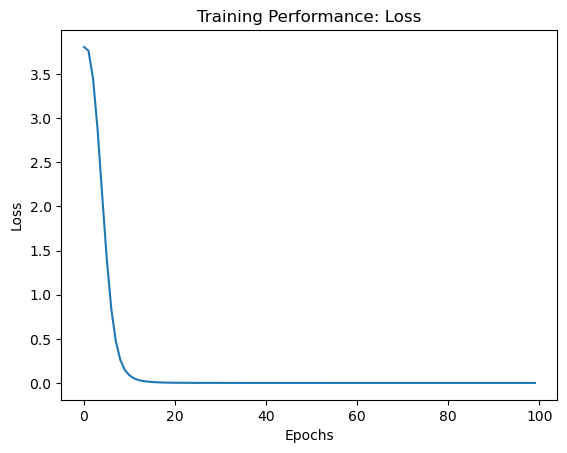

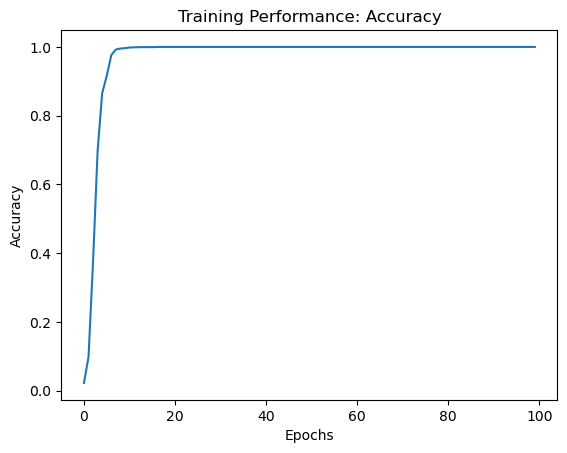

Model test predictions gave an Accuracy of : 0.981859410430839 and Recall of : 0.981859410430839 and a Loss of : 2.725777808194345
Test accuracy with libraries: 0.981859410430839 Recall score: 0.981859410430839 Precision for the test: 0.9836716473740683


In [16]:
# EXPERIMENT 1 TRAINING
exp1_neural_network= ModifiedNeuralNetwork()
trained_parameters, losses, accuracies,recalls = exp1_neural_network.train_neural_network(X_partial_train, y_partial_train, input_size=vocab_size_dense, hidden_size1=128, hidden_size2=64, output_size=num_classes, num_epochs=100, learning_rate=0.02, print_loss=True)

exp1_neural_network.plot_learning(losses, 'Loss')
exp1_neural_network.plot_learning(accuracies, 'Accuracy')

#EVALUATION
exp1_neural_network.evaluate_model_performance(X_validation, y_validation, trained_parameters)

# EXPERIMENT 2 

After completing my initial experiment, I noticed that the loss had decsreased greatly and the accuracy had also peaked to above 90% from 30%. As I continued looking for ways to enhance the performance of my neural network model, I explored alternative weight initialization techniques, including Xavier and He initialization, instead of just randomly initializing the parameters, to mitigate issues such as gradient vanishing or exploding during training,  Furthermore, I introduced regularization techniques. However, during training, I encountered challenges with excessively high loss and descreasing accuracy, leading to premature termination of the training process.

I think that the high learning rate (lr) and strong regularization (l2) parameters might have contributed to the observed issues. Since a high learning rate can cause the model to overshoot the optimal parameters during training, resulting in instability and poor convergence. Similarly, excessive L2 regularization can overly penalize the model's parameters, leading to a high bias and reduced model capacity, thereby hindering its ability to capture complex patterns in the data.

Reducing the learning rate from 0.02 to 0.005 aims to mitigate the overshooting problem by taking smaller steps towards the optimal parameters, thereby enhancing stability and convergence. Additionally, decreasing the regularization parameter from 0.01 to 0.001 aims to strike a better balance between bias and variance in the model. By reducing the strength of regularization, I aim to allow the model more flexibility to capture nuanced patterns in the data without excessively penalizing the parameters.

#### TERMINATED TRAINING CYCLE

In [18]:
class NeuralNetworkExperiment2(ModifiedNeuralNetwork):
    def __init__(self):
        super().__init__()

    def init_params(self, input_size, hidden_size1, hidden_size2, output_size, initialization='xavier'):
        """
        Initialize the parameters of the neural network with specified sizes using either He or Xavier initialization.

        Arguments:
        - input_size: Integer, the size of the input features.
        - hidden_size1: Integer, the number of neurons in the first hidden layer.
        - hidden_size2: Integer, the number of neurons in the second hidden layer.
        - output_size: Integer, the number of neurons in the output layer.

        Returns:
        - parameters: Dictionary, containing the initialized weights and biases for each layer of the neural network.
          - "W": are weights where "b" are biases
        """
        np.random.seed(0)
        if initialization == 'he':
            # He initialization
            W1 = np.random.randn(hidden_size1, input_size) * np.sqrt(2 / input_size)
            W2 = np.random.randn(hidden_size2, hidden_size1) * np.sqrt(2 / hidden_size1)
            W3 = np.random.randn(output_size, hidden_size2) * np.sqrt(2 / hidden_size2)
        elif initialization == 'xavier':
            # Xavier initialization
            W1 = np.random.randn(hidden_size1, input_size) * np.sqrt(1 / input_size)
            W2 = np.random.randn(hidden_size2, hidden_size1) * np.sqrt(1 / hidden_size1)
            W3 = np.random.randn(output_size, hidden_size2) * np.sqrt(1 / hidden_size2)
        else:
            raise ValueError("Invalid initialization type. Use 'he' or 'xavier'.")

        b1 = np.zeros((hidden_size1, 1))
        b2 = np.zeros((hidden_size2, 1))
        b3 = np.zeros((output_size, 1))

        parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3}

        return parameters

    def train_neural_network(self, X, Y, input_size, hidden_size1, hidden_size2, output_size, learning_rate, num_epochs, l2_reg_lambda=0.01, print_loss=True):
        """
        Training a neural network model with stochastic gradient descent with L2 regularization
        Argument: l2_reg_lambda -- Regularization parameter for L2 regularization and the default being 0.01
        Returns:
        parameters -- Trained parameters of the neural network
        losses -- List of loss values at each epoch during training
        accuracies -- List of accuracies at each epoch during training
        """
        parameters = self.init_params(input_size, hidden_size1, hidden_size2, output_size)

        # Initialize variables for optimizer
        v = {key: np.zeros_like(value) for key, value in parameters.items()}
        s = {key: np.zeros_like(value) for key, value in parameters.items()}
        t = 0

        losses = []
        accuracies = []
        recalls = []
        for epoch in range(1, num_epochs + 1):
            A3, cache = self.forward_propagation(X, parameters)
            loss = self.categorical_cross_entropy_loss(A3, Y)

            # L2 regularization
            l2_regularization_cost = 0
            for key in parameters.keys():
                if key.startswith('W'):  # apply regularization to weight matrices only
                    l2_regularization_cost += np.sum(np.square(parameters[key]))
            loss += 0.5 * l2_reg_lambda * l2_regularization_cost

            predictions = self.model_predict(X, parameters)
            train_accuracy = self.compute_accuracy(predictions, Y)
            train_recall = self.compute_recall(predictions, Y)
            gradients = self.backward_propagation(parameters, cache, X, Y)
            t += 1
            parameters, v, s = self.update_parameters(parameters, gradients, v, s, t, learning_rate)

            if print_loss and epoch % 20 == 0:
                print(f"Loss: {loss}, Accuracy: {train_accuracy}  after epoch - {epoch}")

            losses.append(loss)
            accuracies.append(train_accuracy)
            recalls.append(train_recall)

        return parameters, losses, accuracies, recalls

exp2_neural_network= NeuralNetworkExperiment2()

trained_parameters_exp2, losses_exp2, accuracies_exp2, recalls_exp2 = exp2_neural_network.train_neural_network(X_partial_train, y_partial_train, input_size=vocab_size_dense, hidden_size1=128, hidden_size2=64, output_size=num_classes, num_epochs=200, learning_rate=0.02, print_loss=True)




Loss: 13.693848380814426, Accuracy: 1.0  after epoch - 20
Loss: 18.280225800952493, Accuracy: 1.0  after epoch - 40
Loss: 19.327166075238345, Accuracy: 1.0  after epoch - 60
Loss: 19.645304514606543, Accuracy: 1.0  after epoch - 80
Loss: 19.803926071683097, Accuracy: 1.0  after epoch - 100
Loss: 19.895570683362823, Accuracy: 1.0  after epoch - 120
Loss: 19.974860883009665, Accuracy: 1.0  after epoch - 140
Loss: 20.047028694588942, Accuracy: 1.0  after epoch - 160
Loss: 20.14925910027608, Accuracy: 1.0  after epoch - 180
Loss: 20.228653320333606, Accuracy: 1.0  after epoch - 200


#### TRAINING WITH THE REDUCED LEARNING RATE AND L2 PARAMETER

In [18]:
trained_parameters_exp2, losses_exp2, accuracies_exp2, recalls_exp2 = exp2_neural_network.train_neural_network(X_partial_train, y_partial_train, input_size=vocab_size_dense, hidden_size1=128, hidden_size2=64, output_size=num_classes, num_epochs=200, learning_rate=0.005, l2_reg_lambda=0.001,print_loss=True)


Loss: 0.3569134141957302, Accuracy: 0.9969765684051398  after epoch - 20
Loss: 0.4412258142859297, Accuracy: 1.0  after epoch - 40
Loss: 0.47223780820695005, Accuracy: 1.0  after epoch - 60
Loss: 0.48411790561456164, Accuracy: 1.0  after epoch - 80
Loss: 0.4915366716769161, Accuracy: 1.0  after epoch - 100
Loss: 0.49727326499158264, Accuracy: 1.0  after epoch - 120
Loss: 0.502269922768387, Accuracy: 1.0  after epoch - 140
Loss: 0.5070059904978954, Accuracy: 1.0  after epoch - 160
Loss: 0.5116334103278706, Accuracy: 1.0  after epoch - 180
Loss: 0.5162152728877247, Accuracy: 1.0  after epoch - 200


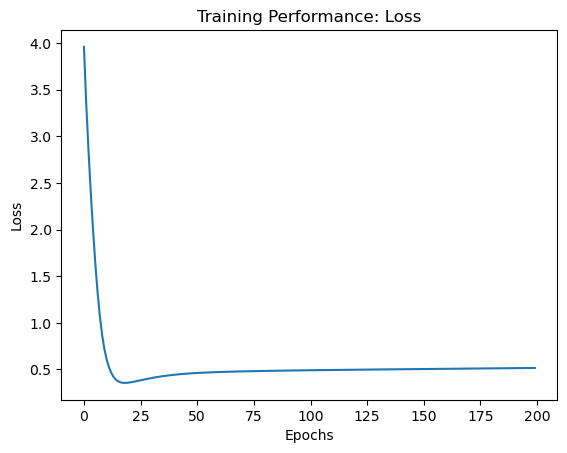

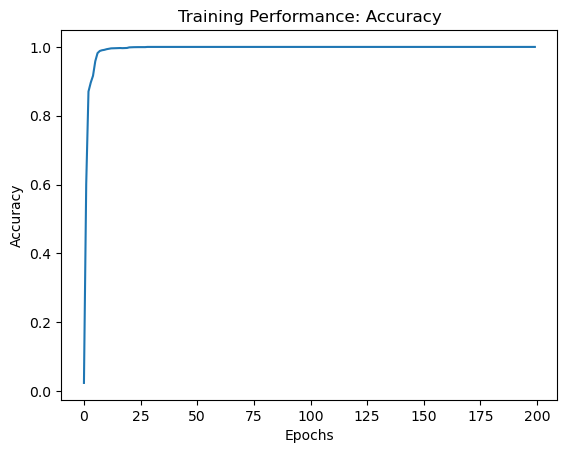

In [19]:
exp2_neural_network.plot_learning(losses_exp2, "Loss")
exp2_neural_network.plot_learning(accuracies_exp2, "Accuracy")


In [20]:
exp2_neural_network.evaluate_model_performance(X_validation , y_validation, trained_parameters_exp2)

Model test predictions gave an Accuracy of : 0.983371126228269 and Recall of : 0.983371126228269 and a Loss of : 2.0168840035143787
Test accuracy with libraries: 0.983371126228269 Recall score: 0.983371126228269 Precision for the test: 0.9844931262457327


# EXPERIMENT 3 
After reducing the learning rate (lr) and L2 regularization parameter, I observed significant improvements in my model's performance, with the accuracy approaching nearly 100%. However, this remarkable achievement prompted me to question whether my model was overfitting, as such high accuracy could indicate that the model was excessively fitting the training data and might not generalize well to unseen data.To address this concern, I introduced K-fold validation, which allowed for parameter fine-tuning and evaluation on previously unseen instances from the training set. This represented a step beyond the initial holdout validation, which solely assessed the model against the validation set post-training. This new approach aimed to shed light on whether the model's impressive accuracy was genuine or merely a byproduct of overfitting.

I also noted that, interestingly, despite the increasing accuracy, there was a concerning trend in the loss function. While accuracy was on the rise, the loss was also increasing steadily. One possible explanation for this phenomenon could be that the model was becoming increasingly confident in its incorrect predictions, leading to higher loss values. Additionally, it could indicate that the model was struggling to fit the training data optimally, despite the improvements in accuracy. Inorder to mitigate these issues, i further reduced the regularisation parameter to 0.001 from 0.005 and i also used cross-fold validation to verify if my model wasn't over fitting. I also changed the way i initilised my parameters from 'xavier' and used 'he'

In [19]:
from sklearn.model_selection import KFold

class NeuralNetworkExperiment3(ModifiedNeuralNetwork):
    def __init__(self):
        super().__init__()
        
        def init_params(self, input_size, hidden_size1, hidden_size2, output_size, initialization='he'):
     
            parameters = super().init_params(input_size, hidden_size1, hidden_size2, output_size)

            return parameters

    def train_neural_network(self,X, Y, input_size, hidden_size1, hidden_size2, output_size, learning_rate,num_epochs, batch_size=64, k_fold_splits=4, l2_reg_lambda=0.001, patience=7,print_loss=True):
        """
        Training a neural network model with k-fold cross-validation, mini-batch gradient descent with L2 regularization, and early stopping.

        Arguments:
        num_epochs -- Number of epochs to train the model
        batch_size -- Size of mini-batches for mini-batch gradient descent.
        k_fold_splits -- Number of splits for k-fold cross-validation (default=4)
        patience -- Number of epochs to wait for the validation loss to improve before stopping training (default=7)
        Returns:
        parameters -- Trained parameters of the neural network.
        """
        kf = KFold(n_splits=k_fold_splits)

        all_train_losses = []
        all_train_accuracies = []
        all_train_recalls = []
        all_val_losses = []
        all_val_accuracies = []
        all_val_recalls = []

        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = Y[train_index], Y[val_index]

            parameters = self.init_params(input_size, hidden_size1, hidden_size2, output_size)
            v = {key: np.zeros_like(value) for key, value in parameters.items()}
            s = {key: np.zeros_like(value) for key, value in parameters.items()}
            t = 0 

            train_losses = []
            train_accuracies = []
            train_recalls = []
            val_losses = []
            val_accuracies = []
            val_recalls = []

            best_val_loss = float('inf')
            patience_count = 0

            num_batches = int(np.ceil(len(X_train) / batch_size))

            for epoch in range(1, num_epochs+1):
                # Shuffling the training data for each epoch
                shuffled_indices = np.random.permutation(len(X_train))
                X_train_shuffled = X_train[shuffled_indices]
                y_train_shuffled = y_train[shuffled_indices]

                for batch in range(num_batches):
                    start = batch * batch_size
                    end = min((batch + 1) * batch_size, len(X_train))
                    X_batch = X_train_shuffled[start:end]
                    y_batch = y_train_shuffled[start:end]

                    # Forward propagation
                    A3_train, cache_train = self.forward_propagation(X_batch, parameters)
                    loss_train = self.categorical_cross_entropy_loss(A3_train, y_batch)
                    l2_regularization_cost = 0
                    for key in parameters.keys():
                        if key.startswith('W'):
                            l2_regularization_cost += np.sum(np.square(parameters[key]))
                    loss_train += 0.5 * l2_reg_lambda * l2_regularization_cost

                    predictions_train = self.model_predict(X_batch, parameters)
                    train_accuracy = self.compute_accuracy(predictions_train, y_batch)
                    train_recall = self.compute_recall(predictions_train, y_batch)

                    # Backward propagation
                    gradients = self.backward_propagation(parameters, cache_train, X_batch, y_batch)
                    t += 1
                    parameters, v, s = self.update_parameters(parameters, gradients, v, s, t, learning_rate)

                # Validation phase after each epoch
                A3_val, _ = self.forward_propagation(X_val, parameters)
                loss_val = self.categorical_cross_entropy_loss(A3_val, y_val)
                predictions_val = self.model_predict(X_val, parameters)
                val_accuracy = self.compute_accuracy(predictions_val, y_val)
                val_recall = self.compute_recall(predictions_val, y_val)
                
                if loss_val < best_val_loss:
                    best_val_loss = loss_val
                    patience_count = 0
                else:
                    patience_count += 1

                if patience_count >= patience:
                    print(f'Early stopping at epoch {epoch} due to no improvement in validation loss.')
                    break

                if print_loss and epoch % 20 == 0:
                    print(f"Epoch {epoch}/{num_epochs} -- Training Loss: {loss_train}, Training Accuracy: {train_accuracy}, Validation Loss: {loss_val}, Validation Accuracy: {val_accuracy}")

                train_losses.append(loss_train)
                train_accuracies.append(train_accuracy)
                train_recalls.append(train_recall)
                val_losses.append(loss_val)
                val_accuracies.append(val_accuracy)
                val_recalls.append(val_recall)

            all_train_losses.append(train_losses)
            all_train_accuracies.append(train_accuracies)
            all_train_recalls.append(train_recalls)
            all_val_losses.append(val_losses)
            all_val_accuracies.append(val_accuracies)
            all_val_recalls.append(val_recalls)

        return parameters, all_train_losses, all_train_accuracies, all_val_losses, all_val_accuracies, all_val_recalls, all_train_recalls



In [22]:
exp3_neural_network= NeuralNetworkExperiment3()

trained_parameters_exp3, train_losses_exp3, train_accuracies_exp3, val_losses_exp3,all_val_accuracies_exp3, all_val_recalls_exp3, all_train_recalls_exp3 = exp3_neural_network.train_neural_network(
    X_partial_train, y_partial_train, input_size=vocab_size_dense, hidden_size1=128, hidden_size2=64, output_size=num_classes, l2_reg_lambda=0.001,num_epochs=200, learning_rate=0.001, print_loss=True
)


Epoch 20/200 -- Training Loss: 0.2370287026933205, Training Accuracy: 1.0, Validation Loss: 0.06012538534281857, Validation Accuracy: 0.9886621315192744
Early stopping at epoch 38 due to no improvement in validation loss.
Epoch 20/200 -- Training Loss: 0.23748579059909766, Training Accuracy: 1.0, Validation Loss: 0.06917980113626554, Validation Accuracy: 0.982615268329554
Early stopping at epoch 38 due to no improvement in validation loss.
Epoch 20/200 -- Training Loss: 0.23793896157254, Training Accuracy: 1.0, Validation Loss: 0.04507094717470618, Validation Accuracy: 0.9879062736205594
Epoch 40/200 -- Training Loss: 0.27131014308970974, Training Accuracy: 1.0, Validation Loss: 0.042355876790074055, Validation Accuracy: 0.9901738473167044
Early stopping at epoch 52 due to no improvement in validation loss.
Epoch 20/200 -- Training Loss: 0.23940679964826278, Training Accuracy: 1.0, Validation Loss: 0.0631284790780599, Validation Accuracy: 0.9848828420256992
Early stopping at epoch 39 d

Model test predictions gave an Accuracy of : 0.981859410430839 and Recall of : 0.981859410430839 and a Loss of : 1.943183765549057
Test accuracy with libraries: 0.981859410430839 Recall score: 0.981859410430839 Precision for the test: 0.9828883632550878


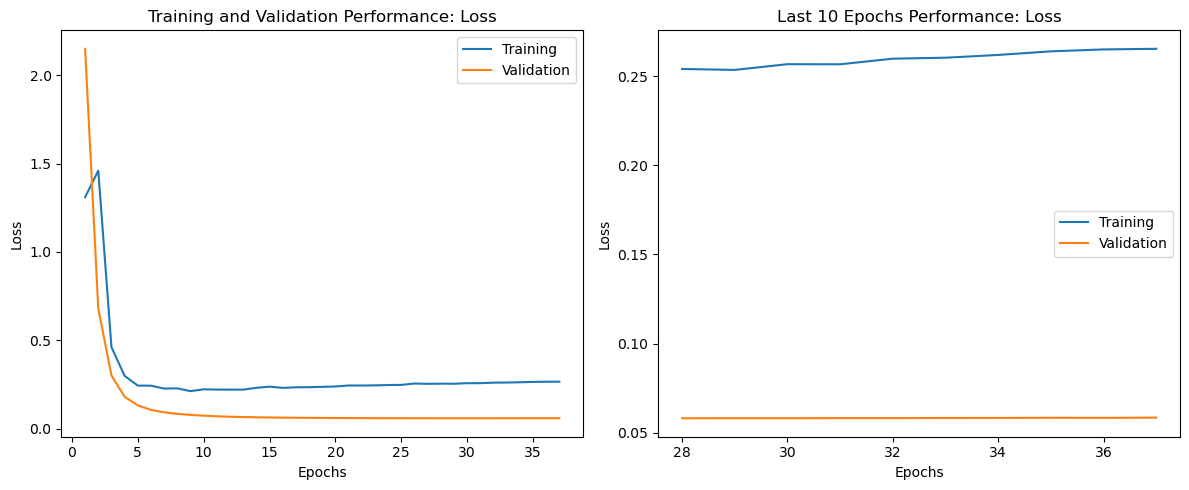

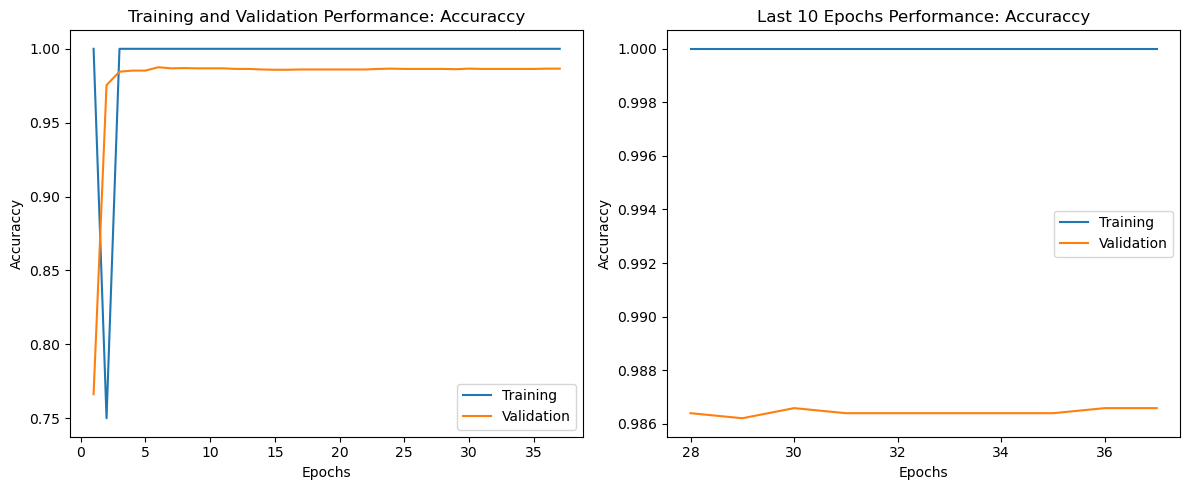

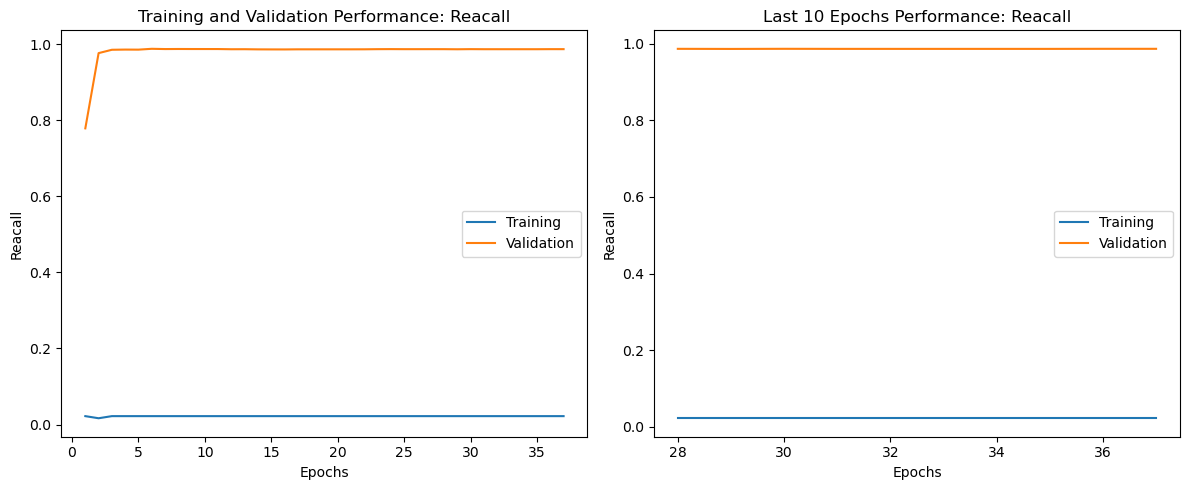

In [23]:
#EVALUATE THE MODEL ON HOLD OUT VALIDATION
exp3_neural_network.evaluate_model_performance(X_validation, y_validation, trained_parameters_exp3)


exp3_neural_network.plot_learning_val(train_losses_exp3, val_losses_exp3, "Loss")
exp3_neural_network.plot_learning_val(train_accuracies_exp3,all_val_accuracies_exp3, "Accuraccy" )
exp3_neural_network.plot_learning_val(all_train_recalls_exp3, all_val_recalls_exp3 ,"Reacall")

# EXPERIMENT 4
The adjustments made have notably enhanced the performance of my model, achieving a training accuracy of nearly 100% while maintaining a validation accuracy above 90%. This indicates minimal to no overfitting. However there was an early stopping at epoch 30 due to no improvement in validation loss.So for my optimal parameters i will use an epoch of 30.

Furthermore, I found that utilizing 'he' for parameter initialization and setting the learning rate to 0.001, along with a validation parameter of the same value, yielded the best results. A notable insight from previous experiments was the significant difference between training and validation accuracy, indicating a potential issue that was identified through validation. This divergence could be attributed to class distribution, as evidenced by the imbalance observed in the class distribution array and even the plot below. To address this, I will try to adjust the calculation of recall to account for class weights.

Despite these challenges, substantial progress has been made, and the model performs reasonably well. However, I am still intrigued by the impact of network width on model performance. In my initial experiment, increasing the number of layers proved beneficial. Now, I aim to explore the effect of widening the network by doubling the number of neurons in each layer to 256 and 128 for the input and first hidden layers, respectively.And also calculate the validation recall accounting for the class weights.


In [30]:
exp4_neural_network= NeuralNetworkExperiment3()

trained_parameters_exp4, train_losses_exp4, train_accuracies_exp4, val_losses_exp4,all_val_accuracies_exp4, all_val_recalls_exp4, all_train_recalls_exp4 = exp4_neural_network.train_neural_network(
    X_partial_train, y_partial_train, input_size=vocab_size_dense, hidden_size1=256, hidden_size2=128, output_size=num_classes, 
    num_epochs=50, learning_rate=0.001, print_loss=True, patience=10
)


Epoch 20/50 -- Training Loss: 0.25687971128066617, Training Accuracy: 1.0, Validation Loss: 0.06346785355088136, Validation Accuracy: 0.9850839030453697
Early stopping at epoch 22 due to no improvement in validation loss.
Epoch 20/50 -- Training Loss: 0.2572395512750499, Training Accuracy: 1.0, Validation Loss: 0.05296544994220674, Validation Accuracy: 0.9863269111249223
Early stopping at epoch 24 due to no improvement in validation loss.
Early stopping at epoch 19 due to no improvement in validation loss.
Epoch 20/50 -- Training Loss: 0.2577209642079049, Training Accuracy: 1.0, Validation Loss: 0.0013847247417968984, Validation Accuracy: 1.0
Epoch 40/50 -- Training Loss: 0.28765738971234855, Training Accuracy: 1.0, Validation Loss: 0.0003362848154426859, Validation Accuracy: 1.0


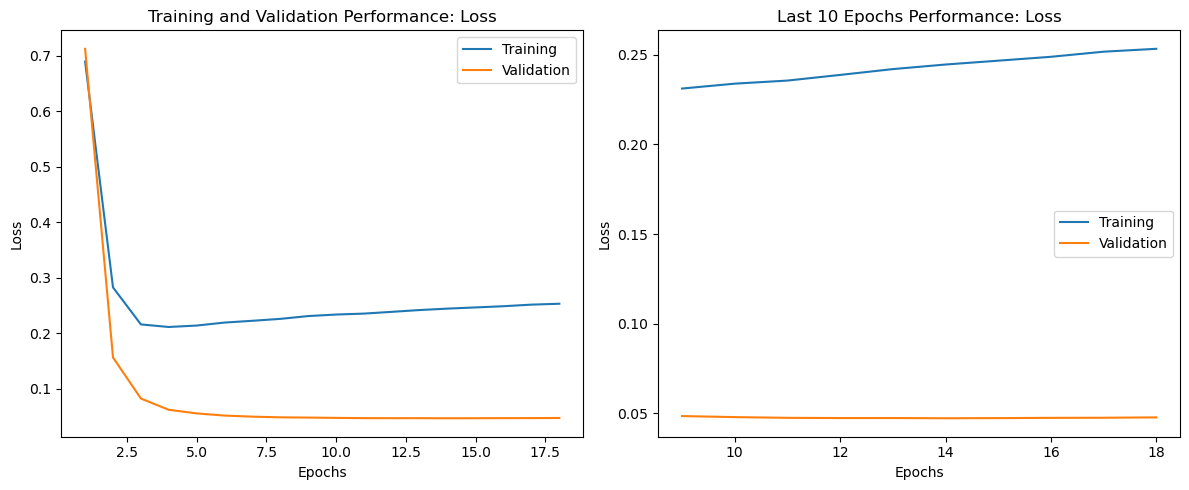

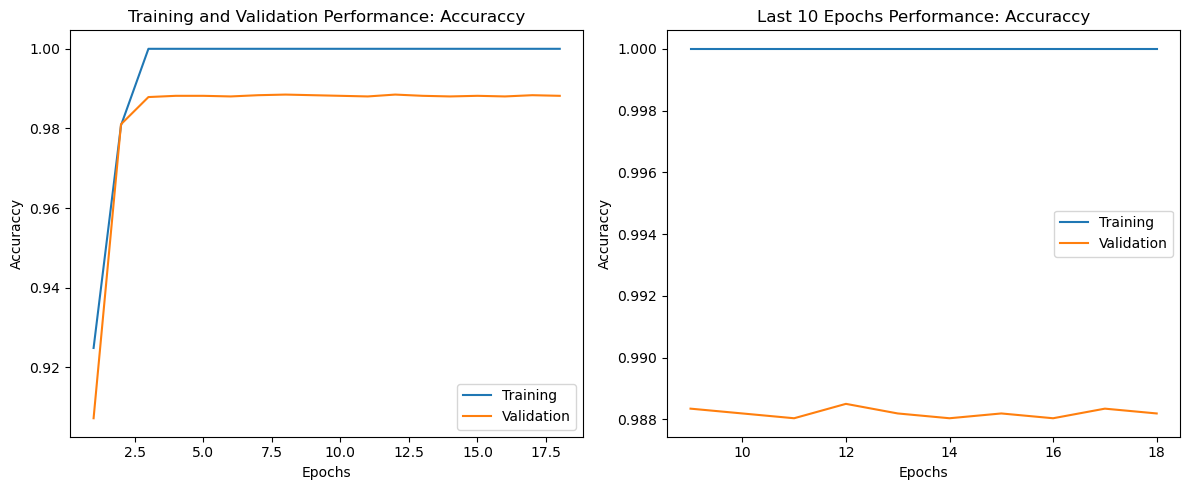

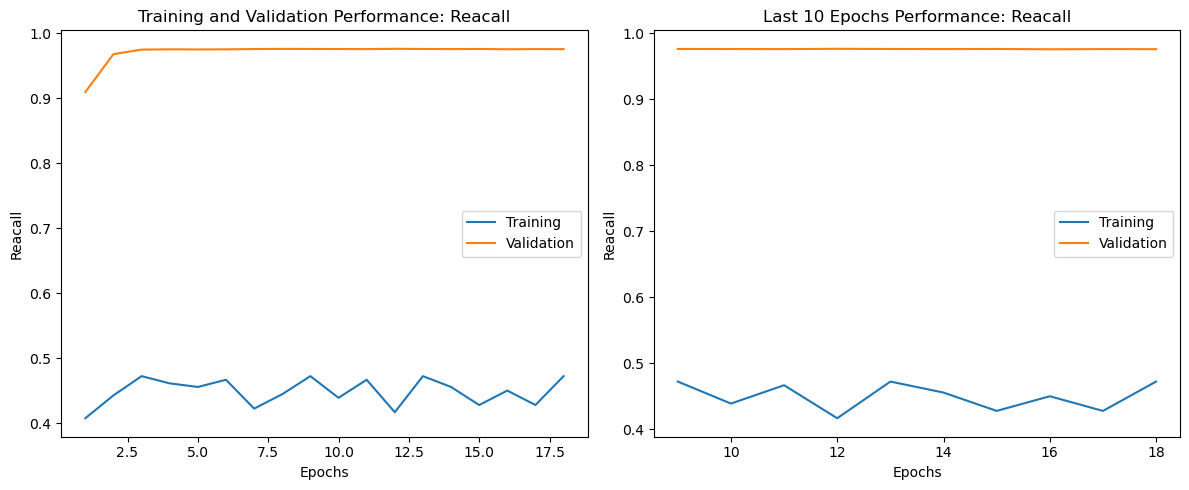

In [31]:
exp4_neural_network.plot_learning_val(train_losses_exp4, val_losses_exp4, "Loss")
exp4_neural_network.plot_learning_val(train_accuracies_exp4,all_val_accuracies_exp4, "Accuraccy" )
exp4_neural_network.plot_learning_val(all_train_recalls_exp4, all_val_recalls_exp4, "Reacall")

In [47]:

exp4_neural_network.evaluate_model_performance(X_validation, y_validation, trained_parameters_exp4)


Model test predictions gave an Accuracy of : 0.9825291181364393 and Recall of : 0.9825291181364393 and a Loss of : 1.8864319822607782
Test accuracy with libraries: 0.9825291181364393 Recall score: 0.9825291181364393 Precision for the test: 0.9838894959492139


In [26]:
#EXPERIMENT WITH A BATCH SIZE OF 32 INSTEAD OF 64

exp4b_neural_network= NeuralNetworkExperiment3()

trained_parameters_exp4b, train_losses_exp4b, train_accuracies_exp4b, val_losses_exp4b,all_val_accuracies_exp4b, all_val_recalls_exp4b, all_train_recalls_exp4b = exp4b_neural_network.train_neural_network(
    X_partial_train, y_partial_train, input_size=vocab_size_dense, hidden_size1=256, hidden_size2=128, output_size=num_classes, 
    num_epochs=50, learning_rate=0.001, print_loss=True, patience=7, batch_size= 32
)
exp4b_neural_network.evaluate_model_performance(X_validation, y_validation, trained_parameters_exp4b)


Early stopping at epoch 18 due to no improvement in validation loss.
Early stopping at epoch 19 due to no improvement in validation loss.
Epoch 20/50 -- Training Loss: 0.2706238273276005, Training Accuracy: 1.0, Validation Loss: 0.027922976775590237, Validation Accuracy: 0.9931972789115646
Early stopping at epoch 26 due to no improvement in validation loss.
Early stopping at epoch 18 due to no improvement in validation loss.
Model test predictions gave an Accuracy of : 0.9841269841269841 and Recall of : 0.9841269841269841 and a Loss of : 1.5622343329354873
Test accuracy with libraries: 0.9841269841269841 Recall score: 0.9841269841269841 Precision for the test: 0.9849227132027227


In [20]:
#CHANGE THE ACTIVATION FUNCTION FOR THE HIDDEN LAYERS FROM TANH TO RELU

class ModifiedNeuralNetwork4b(NeuralNetworkExperiment3):
    def __init__(self):
        super().__init__()  # the parent class

    def forward_propagation(self, X, parameters):
        """
        Perform forward propagation through the neural network.

        Arguments:
        - X: input data.
        - parameters: Dictionary, containing the weights and biases for each layer of the neural network from init_params function

        Returns:
        - A3: Array, shape (num_classes, num_samples), output probabilities for each class.
        - cache: Dictionary, with arrays of shape(layer_size, num_samples)
          - "Z1": preactivation values for the input layer.
          - "A1": activated values for the input layer.
          - "Z2": preactivation values for the 2nd hidden layer.
          - "A2": activation values for the 2nd hidden layer.
          - "Z3": preactivation values for the output layer.
          - "A3": output probabilities for each class.
        """
        W1, b1, W2, b2, W3, b3 = parameters["W1"], parameters["b1"], parameters["W2"], parameters["b2"], parameters[
            "W3"], parameters["b3"]

        # Input layer
        Z1 = np.dot(W1, X.T) + b1  # preactivation layer
        A1 = self.ReLU(Z1)
        # Hidden layer with ReLU
        Z2 = np.dot(W2, A1) + b2
        A2 = self.ReLU(Z2)
        # Output layer with softmax
        Z3 = np.dot(W3, A2) + b3
        A3 = self.softmax(Z3)
        cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2, "Z3": Z3, "A3": A3}
        return A3, cache

    def backward_propagation(self, parameters, cache, X, Y):
        """
        Compute the gradients of the loss with respect to the parameters using backpropagation.

        Arguments:
        X -- Input data, shape (input_size, num_samples)
        Y -- True labels, shape (output_size, num_samples)
        cache -- Dictionary containing the intermediate values from forward propagation
        parameters -- Dictionary containing the model's parameters
        Returns:
        gradients -- Dictionary containing the gradients of the loss with respect to each parameter
        """
        m = X.shape[1]  # number of samples
        W1, b1, W2, b2, W3, b3 = parameters["W1"], parameters["b1"], parameters["W2"], parameters["b2"], parameters[
            "W3"], parameters["b3"]

        # Retrieve cached values
        A1, A2, A3 = cache["A1"], cache["A2"], cache["A3"]
        Z1, Z2, Z3 = cache["Z1"], cache["Z2"], cache["Z3"]

        # Computing gradients
        dZ3 = A3 - Y.T
        dW3 = 1 / m * np.dot(dZ3, A2.T)
        db3 = 1 / m * np.sum(dZ3, axis=1, keepdims=True)

        dA2 = np.dot(W3.T, dZ3)
        dZ2 = np.array(dA2, copy=True)
        dZ2[Z2 <= 0] = 0  # derivative of ReLU activation
        dW2 = 1 / m * np.dot(dZ2, A1.T)
        db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)

        dA1 = np.dot(W2.T, dZ2)
        dZ1 = np.array(dA1, copy=True)
        dZ1[Z1 <= 0] = 0  # derivative of ReLU activation
        dW1 = 1 / m * np.dot(dZ1, X)
        db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)

        gradients = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2, "dW3": dW3, "db3": db3}

        return gradients

  

In [38]:
exp4b2_neural_network = ModifiedNeuralNetwork4b()


trained_parameters_exp4b2, train_losses_exp4b2, train_accuracies_exp4b2, val_losses_exp4b2,all_val_accuracies_exp4b2, all_val_recalls_exp4b2, all_train_recalls_exp4b2 = exp4b2_neural_network.train_neural_network(
    X_partial_train, y_partial_train, input_size=vocab_size_dense, hidden_size1=256, hidden_size2=128, output_size=num_classes, 
    num_epochs=50, learning_rate=0.001, print_loss=True, patience=7, batch_size= 32
)
exp4b2_neural_network.evaluate_model_performance(X_validation, y_validation, trained_parameters_exp4b2)

Early stopping at epoch 11 due to no improvement in validation loss.
Early stopping at epoch 14 due to no improvement in validation loss.
Early stopping at epoch 14 due to no improvement in validation loss.
Early stopping at epoch 12 due to no improvement in validation loss.
Model test predictions gave an Accuracy of : 0.981103552532124 and Recall of : 0.981103552532124 and a Loss of : 1.9783465376742342
Test accuracy with libraries: 0.981103552532124 Recall score: 0.981103552532124 Precision for the test: 0.9817885390208486


# EXPERIMENT 5
In my last experiment, the model evidently performed better with a smaller batch size; this may be because it updated its parameters more frequently because it processed fewer examples per iteration. This can lead to faster convergence, especially in  cases where the loss surface is non-convex or has many local minimaI. I also noticed that making the model wider improved its performance. So, I want to take it a step further and make the model deeper too. I'm going to add another layer to the model, with 128 neurons, to see if this makes it even better. And lastly changing the activation function from tanh to ReLU did not improve the model's perfomance, while the accuarcy and recall remained the same, the loss increased from 1.5 to 1.98. Thus for the optimal paramters i will use tanh activation function for my second hidden layer and ReLU for the first (input) layer.

This experiment is like building on what I've learned before. Each time I try something new, I learn more about how the model works. By adding more layers, I hope to make the model better at understanding the data and making predictions. By broadening and deepening the model, I aim to capture more intricate patterns in the data and enhance the model's capacity to learn and generalize


In [71]:
class NeuralNetworkExperiment5(ModifiedNeuralNetwork):
    def __init__(self):
        super().__init__()  

    def init_params(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, initialization='xavier'):
        np.random.seed(0)
        if initialization == 'he':
            # He initialization
            W1 = np.random.randn(hidden_size1, input_size) * np.sqrt(2 / input_size)
            W2 = np.random.randn(hidden_size2, hidden_size1) * np.sqrt(2 / hidden_size1)
            W3 = np.random.randn(hidden_size3, hidden_size2) * np.sqrt(2 / hidden_size2)
            W4 = np.random.randn(output_size, hidden_size3) * np.sqrt(2 / hidden_size3)
        elif initialization == 'xavier':
            # Xavier initialization
            W1 = np.random.randn(hidden_size1, input_size) * np.sqrt(1 / input_size)
            W2 = np.random.randn(hidden_size2, hidden_size1) * np.sqrt(1 / hidden_size1)
            W3 = np.random.randn(hidden_size3, hidden_size2) * np.sqrt(1 / hidden_size2)
            W4 = np.random.randn(output_size, hidden_size3) * np.sqrt(1 / hidden_size3)
        else:
            raise ValueError("Invalid initialization type. Use 'he' or 'xavier'.")

        b1 = np.zeros((hidden_size1, 1))
        b2 = np.zeros((hidden_size2, 1))
        b3 = np.zeros((hidden_size3, 1))
        b4 = np.zeros((output_size, 1))

        parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3, "W4": W4, "b4": b4}

        return parameters

    def forward_propagation(self, X, parameters):
        W1, b1, W2, b2, W3, b3, W4, b4 = parameters["W1"], parameters["b1"], parameters["W2"], parameters["b2"], parameters["W3"], parameters["b3"], parameters["W4"], parameters["b4"]

        # Input layer
        Z1 = np.dot(W1, X.T) + b1
        A1 = self.ReLU(Z1)

        # First hidden layer
        Z2 = np.dot(W2, A1) + b2
        A2 = self.ReLU(Z2)

        # Additional hidden layer
        Z3 = np.dot(W3, A2) + b3
        A3 = self.tanh(Z3)

        # Output layer
        Z4 = np.dot(W4, A3) + b4
        A4 = self.softmax(Z4)

        cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2, "Z3": Z3, "A3": A3, "Z4": Z4, "A4": A4}

        return A4, cache

    def backward_propagation(self, parameters, cache, X, Y):
        m = X.shape[1]  # number of samples
        W1, b1, W2, b2, W3, b3, W4, b4 = parameters["W1"], parameters["b1"], parameters["W2"], parameters["b2"], parameters["W3"], parameters["b3"], parameters["W4"], parameters["b4"]
        A1, A2, A3, A4 = cache["A1"], cache["A2"], cache["A3"], cache["A4"]
        Z1, Z2, Z3, Z4 = cache["Z1"], cache["Z2"], cache["Z3"], cache["Z4"]

        # Compute gradients for the output layer
        dZ4 = A4 - Y.T
        dW4 = 1 / m * np.dot(dZ4, A3.T)
        db4 = 1 / m * np.sum(dZ4, axis=1, keepdims=True)

        # Compute gradients for the additional hidden layer
        dA3 = np.dot(W4.T, dZ4)
        dZ3 = dA3 * (1 - np.power(A3, 2))  # derivative of tanh activation
        dW3 = 1 / m * np.dot(dZ3, A2.T)
        db3 = 1 / m * np.sum(dZ3, axis=1, keepdims=True)

        # Compute gradients for the 1st hidden layer
        dA2 = np.dot(W3.T, dZ3)
        dZ2 =np.array(dA2,copy=True)
        dZ2[Z2<=0]=0 #derivative of ReLU activation
        dW2 = 1 / m * np.dot(dZ2, A1.T)
        db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)

        # Compute gradients for the input layer
        dA1 = np.dot(W2.T, dZ2)
        dZ1 = np.array(dA1, copy=True)
        dZ1[Z1 <= 0] = 0  # derivative of ReLU activation
        dW1 = 1 / m * np.dot(dZ1, X)
        db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)

        gradients = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2, "dW3": dW3, "db3": db3, "dW4": dW4, "db4": db4}

        return gradients



    def train_neural_network(self, X, Y, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, learning_rate, num_epochs, batch_size=64, k_fold_splits=4, l2_reg_lambda=0.001, patience=10, print_loss=True):
        """
        Training a neural network model with k-fold cross-validation, mini-batch gradient descent with L2 regularization, and early stopping.

        Arguments:
        num_epochs -- Number of epochs to train the model
        batch_size -- Size of mini-batches for mini-batch gradient descent.
        k_fold_splits -- Number of splits for k-fold cross-validation (default=4)
        patience -- Number of epochs to wait for the validation loss to improve before stopping training (default=10)
        Returns:
        parameters -- Trained parameters of the neural network.
        """
        kf = KFold(n_splits=k_fold_splits)

        all_train_losses = []
        all_train_accuracies = []
        all_train_recalls = []
        all_val_losses = []
        all_val_accuracies = []
        all_val_recalls = []

        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = Y[train_index], Y[val_index]

            parameters = self.init_params(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)
            v = {key: np.zeros_like(value) for key, value in parameters.items()}
            s = {key: np.zeros_like(value) for key, value in parameters.items()}
            t = 0 

            train_losses = []
            train_accuracies = []
            train_recalls = []
            val_losses = []
            val_accuracies = []
            val_recalls = []

            best_val_loss = float('inf')
            patience_count = 0

            num_batches = int(np.ceil(len(X_train) / batch_size))

            for epoch in range(1, num_epochs+1):
                # Shuffling the training data for each epoch
                shuffled_indices = np.random.permutation(len(X_train))
                X_train_shuffled = X_train[shuffled_indices]
                y_train_shuffled = y_train[shuffled_indices]

                for batch in range(num_batches):
                    start = batch * batch_size
                    end = min((batch + 1) * batch_size, len(X_train))
                    X_batch = X_train_shuffled[start:end]
                    y_batch = y_train_shuffled[start:end]

                    # Forward propagation
                    A4_train, cache_train = self.forward_propagation(X_batch, parameters)
                    loss_train = self.categorical_cross_entropy_loss(A4_train, y_batch)
                    l2_regularization_cost = 0
                    for key in parameters.keys():
                        if key.startswith('W'):
                            l2_regularization_cost += np.sum(np.square(parameters[key]))
                    loss_train += 0.5 * l2_reg_lambda * l2_regularization_cost

                    predictions_train = self.model_predict(X_batch, parameters)
                    train_accuracy = self.compute_accuracy(predictions_train, y_batch)
                    train_recall = self.compute_recall(predictions_train, y_batch)

                    # Backward propagation
                    gradients = self.backward_propagation(parameters, cache_train, X_batch, y_batch)
                    t += 1
                    parameters, v, s = self.update_parameters(parameters, gradients, v, s, t, learning_rate)

                # Validation phase after each epoch
                A4_val, _ = self.forward_propagation(X_val, parameters)
                loss_val = self.categorical_cross_entropy_loss(A4_val, y_val)
                predictions_val = self.model_predict(X_val, parameters)
                val_accuracy = self.compute_accuracy(predictions_val, y_val)
                val_recall = self.compute_recall(predictions_val, y_val)

                if loss_val < best_val_loss:
                    best_val_loss = loss_val
                    patience_count = 0
                else:
                    patience_count += 1

                if patience_count >= patience:
                    print(f'Early stopping at epoch {epoch} due to no improvement in validation loss.')
                    break

                if print_loss and epoch % 20 == 0:
                    print(f"Epoch {epoch}/{num_epochs} -- Training Loss: {loss_train}, Training Accuracy: {train_accuracy}, Validation Loss: {loss_val}, Validation Accuracy: {val_accuracy}")

                train_losses.append(loss_train)
                train_accuracies.append(train_accuracy)
                train_recalls.append(train_recall)
                val_losses.append(loss_val)
                val_accuracies.append(val_accuracy)
                val_recalls.append(val_recall)

            all_train_losses.append(train_losses)
            all_train_accuracies.append(train_accuracies)
            all_train_recalls.append(train_recalls)
            all_val_losses.append(val_losses)
            all_val_accuracies.append(val_accuracies)
            all_val_recalls.append(val_recalls)

        return parameters, all_train_losses, all_train_accuracies, all_val_losses, all_val_accuracies, all_val_recalls, all_train_recalls


Epoch 20/50 -- Training Loss: 0.39595579261097896, Training Accuracy: 1.0, Validation Loss: 0.04302919078252961, Validation Accuracy: 0.9909297052154195
Early stopping at epoch 28 due to no improvement in validation loss.
Epoch 20/50 -- Training Loss: 0.3974140597525751, Training Accuracy: 1.0, Validation Loss: 0.058307151495440857, Validation Accuracy: 0.9856386999244142
Early stopping at epoch 33 due to no improvement in validation loss.
Epoch 20/50 -- Training Loss: 0.39770547476774987, Training Accuracy: 1.0, Validation Loss: 0.03970437965002406, Validation Accuracy: 0.9894179894179894
Epoch 40/50 -- Training Loss: 0.4242248812549883, Training Accuracy: 1.0, Validation Loss: 0.03858438073813033, Validation Accuracy: 0.9909297052154195
Early stopping at epoch 44 due to no improvement in validation loss.
Epoch 20/50 -- Training Loss: 0.39757674826111145, Training Accuracy: 1.0, Validation Loss: 0.06612046796290014, Validation Accuracy: 0.9803476946334089
Early stopping at epoch 26 du

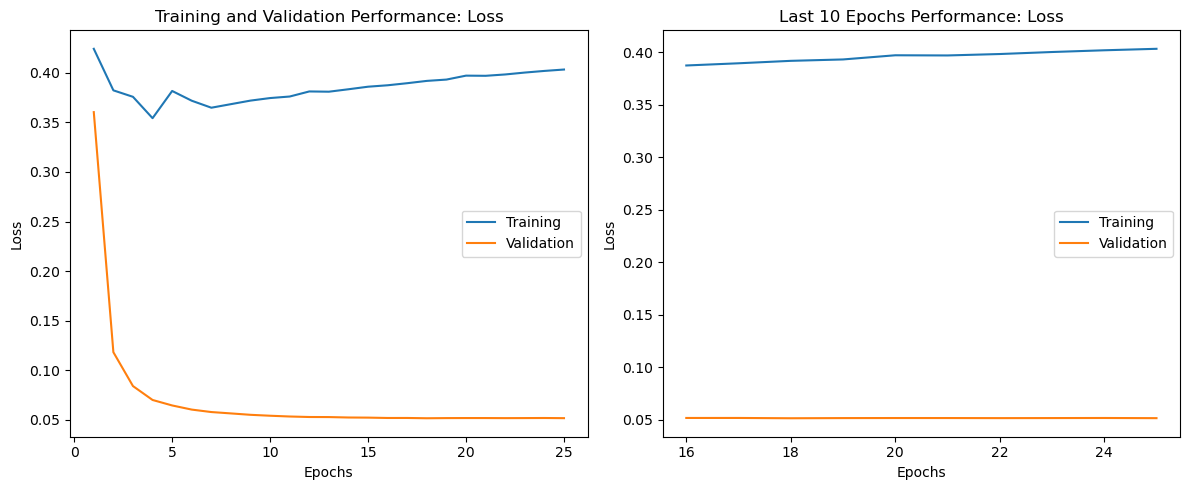

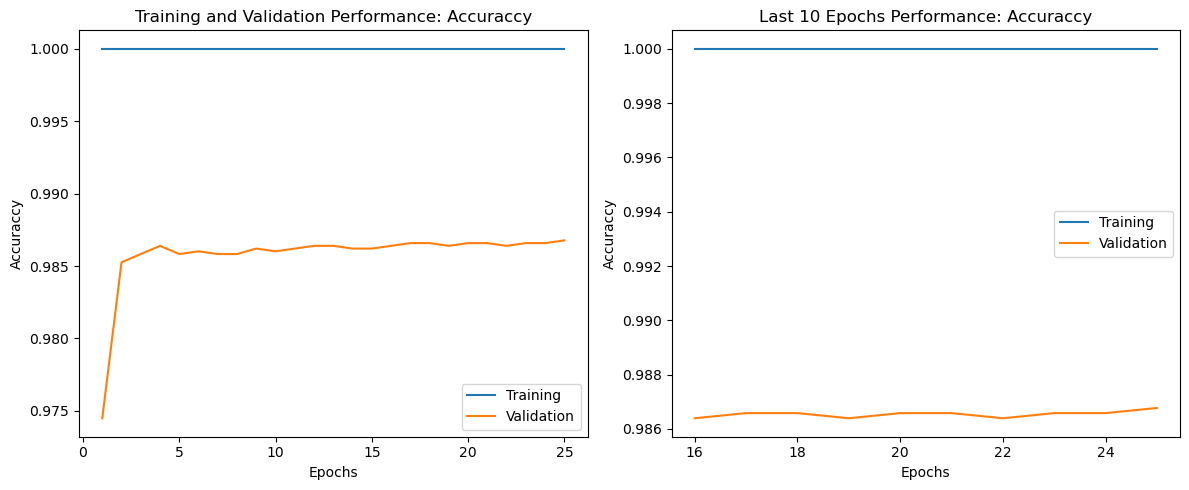

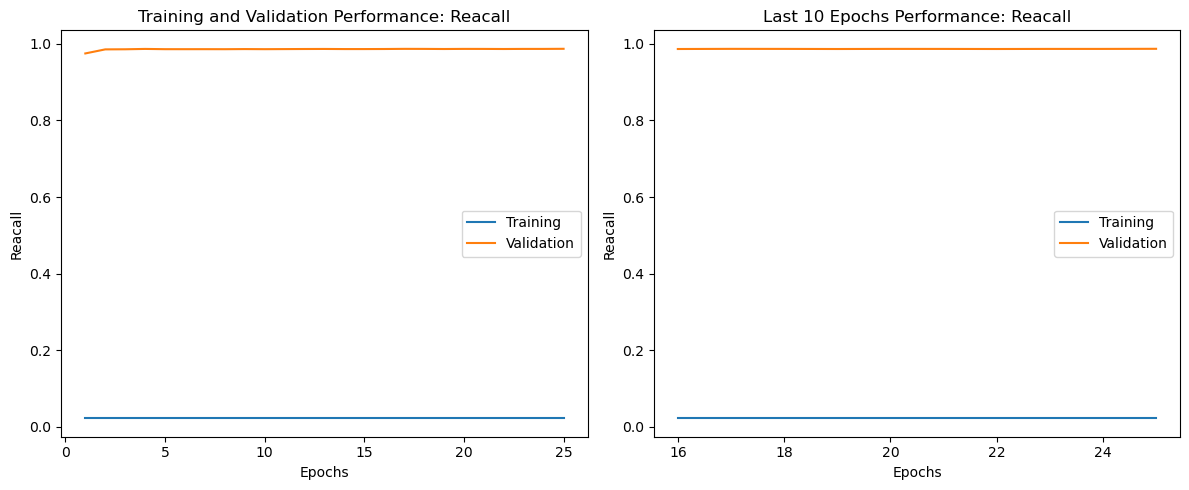

Model test predictions gave an Accuracy of : 0.981859410430839 and Recall of : 0.981859410430839 and a Loss of : 1.8529997574562465
Test accuracy with libraries: 0.981859410430839 Recall score: 0.981859410430839 Precision for the test: 0.9826410420021273


In [25]:
exp5_neural_network= NeuralNetworkExperiment5()


trained_parameters_exp5, train_losses_exp5, train_accuracies_exp5, val_losses_exp5,all_val_accuracies_exp5, all_val_recalls_exp5, all_train_recalls_exp5 = exp5_neural_network.train_neural_network(X_partial_train, y_partial_train, input_size=vocab_size_dense, hidden_size1=256, hidden_size2=128, hidden_size3=64, output_size=num_classes, num_epochs=50, learning_rate=0.001, print_loss=True)


exp5_neural_network.plot_learning_val(train_losses_exp5, val_losses_exp5, "Loss")
exp5_neural_network.plot_learning_val(train_accuracies_exp5,all_val_accuracies_exp5, "Accuraccy" )
exp5_neural_network.plot_learning_val(all_train_recalls_exp5, all_val_recalls_exp5, "Reacall")
exp5_neural_network.evaluate_model_performance(X_validation, y_validation, trained_parameters_exp5)
# Accuracy: 0.9925457570715474 and Recall: 0.9925457570715474 and a Loss : 1.9859610453816567 Precision : 0.9941595452349343

# Optimizing Model Parameters

Based on insights gained from the previous experiment, I've observed that increasing the depth of the network didn't significantly enhance the model's performance. Given the relatively modest complexity of my problem—having only 45 classes and a single-column feature—utilizing a model with three hidden layers may not be the most efficient approach.

For this final training iteration, I'll opt for a simpler architecture, employing just two hidden layers with 256 and 128 neurons for the first and second layers, respectively. This streamlined structure is expected to strike a better balance between complexity and performance.

To facilitate robust learning, I'll set the learning rate to 0.001 and adjust the lambda parameter for L2 regularization to 0.001. Initializing parameters using the 'he' method ensures a robust starting point for training.

Furthermore, to prevent overfitting and facilitate smoother convergence, I'll train the model for 30 epochs with a moderate batch size of 32. This setup strikes a balance between computational efficiency and effective parameter optimization.

In this training phase, I'll utilize all available training data, including both the partial training and validation data. By leveraging the entire dataset, I aim to maximize the model's exposure to diverse patterns and enhance its generalization capabilities.

In [ ]:
from sklearn.model_selection import KFold, ParameterGrid

class FinalTraining(NeuralNetworkExperiment3):
    def __init__(self):
        super().__init__()

    def train_neural_network(self, X, Y, input_size, hidden_size1, hidden_size2, output_size, learning_rate, num_epochs, batch_size, k_fold_splits, l2_reg_lambda, print_loss=True):
        """
        Training a neural network model with k-fold cross-validation, mini-batch gradient descent with L2 regularization, and early stopping.

        Arguments:
        num_epochs -- Number of epochs to train the model
        batch_size -- Size of mini-batches for mini-batch gradient descent.
        k_fold_splits -- Number of splits for k-fold cross-validation (default=4)
        Returns:
        parameters -- Trained parameters of the neural network.
        """
        kf = KFold(n_splits=k_fold_splits)

        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = Y[train_index], Y[val_index]

            parameters = self.init_params(input_size, hidden_size1, hidden_size2, output_size)
            v = {key: np.zeros_like(value) for key, value in parameters.items()}
            s = {key: np.zeros_like(value) for key, value in parameters.items()}
            t = 0

            best_val_loss = float('inf')

            num_batches = int(np.ceil(len(X_train) / batch_size))

            for epoch in range(1, num_epochs+1):
                # Shuffling the training data for each epoch
                shuffled_indices = np.random.permutation(len(X_train))
                X_train_shuffled = X_train[shuffled_indices]
                y_train_shuffled = y_train[shuffled_indices]

                for batch in range(num_batches):
                    start = batch * batch_size
                    end = min((batch + 1) * batch_size, len(X_train))
                    X_batch = X_train_shuffled[start:end]
                    y_batch = y_train_shuffled[start:end]

                    # Forward propagation
                    A3_train, cache_train = self.forward_propagation(X_batch, parameters)
                    loss_train = self.categorical_cross_entropy_loss(A3_train, y_batch)
                    l2_regularization_cost = 0
                    for key in parameters.keys():
                        if key.startswith('W'):
                            l2_regularization_cost += np.sum(np.square(parameters[key]))
                    loss_train += 0.5 * l2_reg_lambda * l2_regularization_cost

                    # Backward propagation
                    gradients = self.backward_propagation(parameters, cache_train, X_batch, y_batch)
                    t += 1
                    parameters, v, s = self.update_parameters(parameters, gradients, v, s, t, learning_rate)

                # Validation phase after each epoch
                A3_val, _ = self.forward_propagation(X_val, parameters)

                if print_loss and epoch % 20 == 0:
                    print(f"Epoch {epoch}/{num_epochs} -- Training Loss: {loss_train}")

        return parameters

    def grid_search(self, X, Y, input_size, output_size, k_fold_splits=4, print_loss=True):
        best_params = None
        best_accuracy = 0

        # Define hyperparameter ranges
        param_grid = {
            'learning_rate': [0.01, 0.001],
            'num_epochs': [50, 30],
            'batch_size': [32,64, 128],
            'hidden_size1': [64, 128, 256],
            'hidden_size2': [32, 64, 128],
            'l2_reg_lambda': [0.001, 0.0001, 0.0005]
        }

        # Define KFold object
        kf = KFold(n_splits=k_fold_splits)

        # Perform grid search
        for params in ParameterGrid(param_grid):
            fold_accuracies = []
            for train_index, val_index in kf.split(X):
                X_train, X_val = X[train_index], X[val_index]
                y_train, y_val = Y[train_index], Y[val_index]
                parameters = self.train_neural_network(X_train, y_train, input_size, params['hidden_size1'], params['hidden_size2'], output_size, params['learning_rate'], params['num_epochs'], params['batch_size'], 4, params['l2_reg_lambda'], False)
                predictions_val = self.model_predict(X_val, parameters)
                val_accuracy = self.compute_accuracy(predictions_val, y_val)
                fold_accuracies.append(val_accuracy)

            # Calculate average accuracy across folds
            average_accuracy = np.mean(fold_accuracies)

            # Update best parameters if current parameters yield better accuracy
            if average_accuracy > best_accuracy:
                best_accuracy = average_accuracy
                best_params = params

            if print_loss:
                print(f"Parameters: {params} -- Average Validation Accuracy: {average_accuracy}")

        print(f"Best Parameters: {best_params} -- Best Validation Accuracy: {best_accuracy}")

        return best_params

# Define hyperparameter ranges

# Instantiate your FinalTraining class
final_training = FinalTraining()

best_params = final_training.grid_search(X_train_dense, y_train_dense, vocab_size_dense, num_classes)


Parameters: {'batch_size': 32, 'hidden_size1': 64, 'hidden_size2': 32, 'l2_reg_lambda': 0.001, 'learning_rate': 0.01, 'num_epochs': 50} -- Average Validation Accuracy: 0.9824074074074074
Parameters: {'batch_size': 32, 'hidden_size1': 64, 'hidden_size2': 32, 'l2_reg_lambda': 0.001, 'learning_rate': 0.01, 'num_epochs': 30} -- Average Validation Accuracy: 0.9825617283950617
Parameters: {'batch_size': 32, 'hidden_size1': 64, 'hidden_size2': 32, 'l2_reg_lambda': 0.001, 'learning_rate': 0.001, 'num_epochs': 50} -- Average Validation Accuracy: 0.9845679012345678
Parameters: {'batch_size': 32, 'hidden_size1': 64, 'hidden_size2': 32, 'l2_reg_lambda': 0.001, 'learning_rate': 0.001, 'num_epochs': 30} -- Average Validation Accuracy: 0.9833333333333334
Parameters: {'batch_size': 32, 'hidden_size1': 64, 'hidden_size2': 32, 'l2_reg_lambda': 0.0001, 'learning_rate': 0.01, 'num_epochs': 50} -- Average Validation Accuracy: 0.9824074074074074
Parameters: {'batch_size': 32, 'hidden_size1': 64, 'hidden_siz

The flow of calculations visually, matching the inputs to the outputs through each layer of the neural network. 
```
Input Layer (x):       [x1, x2, ..., x175]           (Shape: 1 x 175)

                                    |  Weighted Sum (z1)   Activation (a1)
                                    V          |                    |
                                +-----------+  |  +-----------+     |
                                |           |  |  |           |     |
                                |    w1     |  |  | ReLU (ReLU)|    |
                                | (175 x 128)|  |  | (128 neurons)  |
                                |           |  |  |           |     |
                                +-----------+  |  +-----------+     |
                                    |          |        |           |
                                    |          V        V           V
                                    |       +----------------+   +----------------+
                                    |       |                |   |                |
                                    +------>|   Bias (b1)    +-->|   Weighted Sum (z2)   Activation (a2)
                                            |  (1 x 128)     |   |       |                     |
                                            |                |   |       V                     |
                                            +----------------+   +----------------+            |
                                                                                   |           |
                                                                                   |           |
                                                                                    ----------+
                                                                                               |
                                                                                               V
                                                                                      +----------------+
                                                                                      |                |
                                                                                      |    w2          |     
                                                                                      | (128 x 64)     |
                                                                                      |                |
                                                                                      +----------------+
                                                                                              |
                                                                                              |
                                                                                              V
                                                                                     +----------------+
                                                                                     |                |
                                                                                     |    Bias (b2)   +------> Output Layer (z3)
                                                                                     |  (1 x 64)      |
                                                                                     |                |
                                                                                     +----------------+
                                                                                              |
                                                                                              |
                                                                                              V
                                                                                     +----------------+
                                                                                     |                |
                                                                                     |    w3          |
                                                                                     | (64 x 45)      |
                                                                                     |                |
                                                                                     +----------------+
                                                                                              |
                                                                                              |
                                                                                              V
                                                                                     +----------------+
                                                                                     |                |
                                                                                     |    Bias (b3)   |
                                                                                     |  (1 x 45)      |
                                                                                     |                |
                                                                                     +----------------+
                                                                                              |
                                                                                              |
                                                                                              V
                                                                                     +----------------+
                                                                                     |                |
                                                                                     |    Softmax     |
                                                                                     |                |
                                                                                     +----------------+
                                                                                              |
                                                                                              |
                                                                                              V
                                                                                     +----------------+
                                                                                     |                |
                                                                                     |   Predicted    |
                                                                                     |   Disease      |
                                                                                     |   Label        |
                                                                                     |   Probabilities|
                                                                                     +----------------+
```

This visual representation shows how the inputs (x) are passed through each layer of the neural network, including the weighted sum calculation, the application of activation functions (ReLU and tanh), and the softmax function at the output layer to obtain the predicted label probabilities.

In [22]:
from sklearn.model_selection import KFold

class FinalTraining(NeuralNetworkExperiment3):
    def __init__(self):
        super().__init__()

    def train_neural_network(self, X, Y, input_size, hidden_size1, hidden_size2, output_size, learning_rate, num_epochs, batch_size=64, l2_reg_lambda=0.001, print_loss=True):
        parameters = self.init_params(input_size, hidden_size1, hidden_size2, output_size)
        v = {key: np.zeros_like(value) for key, value in parameters.items()}
        s = {key: np.zeros_like(value) for key, value in parameters.items()}
        t = 0 

        num_batches = int(np.ceil(len(X) / batch_size))

        for epoch in range(1, num_epochs+1):
            # Shuffling the training data for each epoch
            shuffled_indices = np.random.permutation(len(X))
            X_shuffled = X[shuffled_indices]
            Y_shuffled = Y[shuffled_indices]

            for batch in range(num_batches):
                start = batch * batch_size
                end = min((batch + 1) * batch_size, len(X))
                X_batch = X_shuffled[start:end]
                y_batch = Y_shuffled[start:end]

                # Forward propagation
                A3_train, cache_train = self.forward_propagation(X_batch, parameters)
                loss_train = self.categorical_cross_entropy_loss(A3_train, y_batch)
                l2_regularization_cost = 0
                for key in parameters.keys():
                    if key.startswith('W'):
                        l2_regularization_cost += np.sum(np.square(parameters[key]))
                loss_train += 0.5 * l2_reg_lambda * l2_regularization_cost

                predictions_train = self.model_predict(X_batch, parameters)
                train_accuracy = self.compute_accuracy(predictions_train, y_batch)
                train_recall = self.compute_recall(predictions_train, y_batch)

                # Backward propagation
                gradients = self.backward_propagation(parameters, cache_train, X_batch, y_batch)
                t += 1
                parameters, v, s = self.update_parameters(parameters, gradients, v, s, t, learning_rate)

            if print_loss and epoch % 10 == 0:
                print(f"Epoch {epoch}/{num_epochs} -- Training Loss: {loss_train}, Training Accuracy: {train_accuracy}")

        return parameters


In [23]:
final_neural_network= FinalTraining()

trained_parameters_final= final_neural_network.train_neural_network(
    X_train_dense, y_train_dense, input_size=vocab_size_dense, hidden_size1=256, hidden_size2=128, output_size=num_classes, 
    num_epochs=50, learning_rate=0.001, print_loss=True, batch_size= 32, l2_reg_lambda=0.001
)


KeyboardInterrupt: 

In [57]:
from sklearn.decomposition import PCA

# Assume X_train is your training data

# Step 1: Fit PCA
pca = PCA(n_components=175)
pca.fit(X_train_dense)

# Step 2: Determine explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Step 3: Calculate cumulative explained variance
cumulative_variance_ratio = explained_variance_ratio.cumsum()

# Step 4: Choose number of components to retain desired variance
desired_variance = 1 # Example: retain 90% of the variance
n_components = (cumulative_variance_ratio < desired_variance).sum() + 1

print("Number of components to retain {}% variance: {}".format(desired_variance * 100, n_components))

X_train_pca = pca.transform(X_train_dense)
X_test_pca = pca.transform(X_test_dense)
X_train_pca.shape


Number of components to retain 100% variance: 176


(6435, 175)

In [58]:
final_neural_network1= FinalTraining()
input_size = X_train_pca.shape[1] 
trained_parameters_final1= final_neural_network1.train_neural_network(
    X_train_pca, y_train_dense, input_size=input_size, hidden_size1=256, hidden_size2=128, output_size=num_classes, 
    num_epochs=50, learning_rate=0.001, print_loss=True, batch_size= 32, l2_reg_lambda=0.001
)


Epoch 10/50 -- Training Loss: 0.2237001724660106, Training Accuracy: 1.0
Epoch 20/50 -- Training Loss: 0.25420888476704, Training Accuracy: 1.0
Epoch 30/50 -- Training Loss: 0.27713953648795975, Training Accuracy: 1.0
Epoch 40/50 -- Training Loss: 0.29916411198738785, Training Accuracy: 1.0
Epoch 50/50 -- Training Loss: 0.3207868379280549, Training Accuracy: 1.0


In [59]:
final_neural_network1.evaluate_model_performance(X_test_pca, y_test, trained_parameters_final1)

Model test predictions gave an Accuracy of : 0.9875207986688852 and Recall of : 0.9875207986688852 and a Loss of : 1.529834500729996
Test accuracy with libraries: 0.9875207986688852 Recall score: 0.9875207986688852 Precision for the test: 0.9880483148698488


In [48]:
final_neural_network.evaluate_model_performance(X_test_dense, y_test, trained_parameters_final)

Model test predictions gave an Accuracy of : 0.9891846921797005 and Recall of : 0.9891846921797005 and a Loss of : 1.24857742098501
Test accuracy with libraries: 0.9891846921797005 Recall score: 0.9891846921797005 Precision for the test: 0.9896452790826621


# COMPARING MY MODEL TO MODELS BUILD WITH KERAS LIBRARY

After achieving remarkable performance with my custom-built neural network model, which attained an accuracy of 98.9%, a recall of 98.9%, a loss of 1.2, and a precision of 98.9%, I'm now intrigued to explore the effectiveness of employing neural network architectures implemented using the Keras library. 

The primary motivation behind this exploration stems from the nature of my dataset, which consists of user-input symptoms for predicting diseases. Unlike conventional numerical data, text data poses unique challenges due to its inherent complexity and variability. Hence, leveraging techniques specifically tailored for text processing, such as embedding layers, might offer superior performance compared to traditional dense layers.

Embedding layers are particularly adept at encoding textual data into low-dimensional vector representations, where words with similar meanings are mapped closer together in the embedding space. This property enables neural networks to effectively capture semantic relationships among words and phrases, thereby enhancing the model's ability to discern patterns and make accurate predictions based on textual inputs.

By experimenting with embedding layers alongside my custom model, I aim to assess their comparative performance in disease prediction tasks. While my custom model has demonstrated exceptional capabilities, incorporating embedding layers offers a potential avenue for further improvement, especially when dealing with text data.

For a fair comparison between the two approaches, I will ensure consistency in hyperparameters across both models. Specifically, I will employ a batch size of 32, train for 50 epochs, utilize two hidden layers with ReLU and Tanh activations with 256 and 128 neurons, respectively. Additionally, I will incorporate L2 regularization with a lambda value of 0.001, and employ mini-batch gradient descent with Adam optimization and a learning rate of 0.001.

Through this comparative analysis, I aim to gain deeper insights into the effectiveness of different neural network architectures for disease prediction tasks, thereby informing future model development efforts and advancing the field of medical AI.

In [56]:
from keras.models import Sequential
from keras import layers
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras import models, layers, utils

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        c = ['\b|', '\b/', '\b-', '\b\\'] 
        print(c[epoch % 4], end='')
    def on_epoch_end(self, epoch, logs=None):
        print('\b', end='')
        keys = list(logs.keys())
        if(epoch<2):
            print("End epoch {} of training; got log keys: {}".format(epoch, keys))
        
input_dim = X_train_dense.shape[1]       
 # Model architecture       
def create_model(optimizer='adam', dropout_rate=0.1, num_layers=2, units_per_layer=256):
    model = models.Sequential()
    model.add(layers.Dense(units_per_layer, activation='relu', input_shape=(input_dim,)))
    for _ in range(num_layers - 1):
        model.add(layers.Dense(units_per_layer/2, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
        model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

    return model

model = create_model()
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 256)               345088    
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 45)                5805      
                                                                 
Total params: 383789 (1.46 MB)
Trainable params: 383789 (1.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [64]:
from sklearn.model_selection import KFold

def k_fold_validation_training(model, X_partial_train, y_partial_train, num_epochs=50, batch_size=32, K=4):
    """
    Perform K-fold cross-validation training for a Keras model.

    Arguments:
    model: Keras model object.
    X_partial_train: Input data for training.
    y_partial_train: Target labels for training.
    num_epochs: Number of epochs for training each fold (default=50).
    batch_size: Batch size for training (default=32).
    K: Number of folds for K-fold cross-validation (default=4).

    Returns:
    avg_loss_history: Average loss history across all folds.
    avg_accuracy_history: Average accuracy history across all folds.
    """
    # Save initial weights
    initial_weights_path = "initial_weights.h5"
    model.save_weights(initial_weights_path)
    all_histories= []

    # Create a KFold object
    kf = KFold(n_splits=K)

    # Iterate over each fold
    for train_index, val_index in kf.split(X_partial_train):
        print('Processing fold')
        
        # Load initial weights before training each fold
        model.load_weights(initial_weights_path)
        
        # Get train and validation data for this fold
        partial_train_data, val_data = X_partial_train[train_index], X_partial_train[val_index]
        partial_train_targets, val_targets = y_partial_train[train_index], y_partial_train[val_index]
        
        # Train the model
        history = model.fit(partial_train_data, partial_train_targets,
                            validation_data=(val_data, val_targets),
                            epochs=num_epochs, batch_size=batch_size, verbose=0)
    
        
        # Append to overall histories
        all_histories.append(history)

    return all_histories

all_histories = k_fold_validation_training(model, X_partial_train, y_partial_train, num_epochs=50, batch_size=32, K=4)

Processing fold
Processing fold
Processing fold
Processing fold


In [65]:
loss, accuracy, precision, recall_metric = model.evaluate(X_validation, y_validation)
# Print the evaluation results
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall (Keras metric):", recall_metric)


42/42 [==============================] - 0s 3ms/step - loss: 0.0584 - accuracy: 0.9864 - recall_2: 0.9826 - precision_2: 0.9878
Test Loss: 0.05840398371219635
Test Accuracy: 0.9863945841789246
Test Precision: 0.9826152920722961
Test Recall (Keras metric): 0.9878419637680054


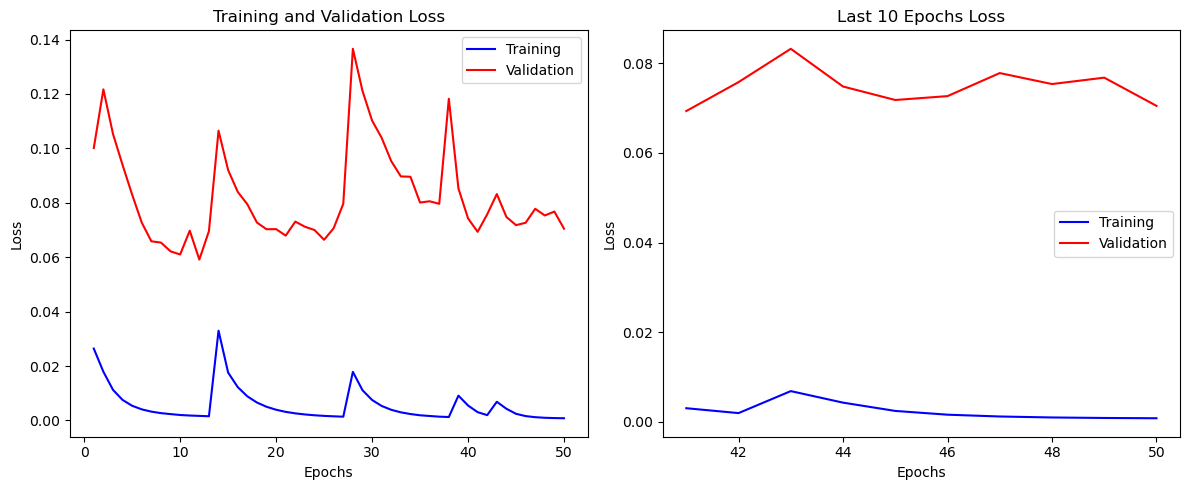

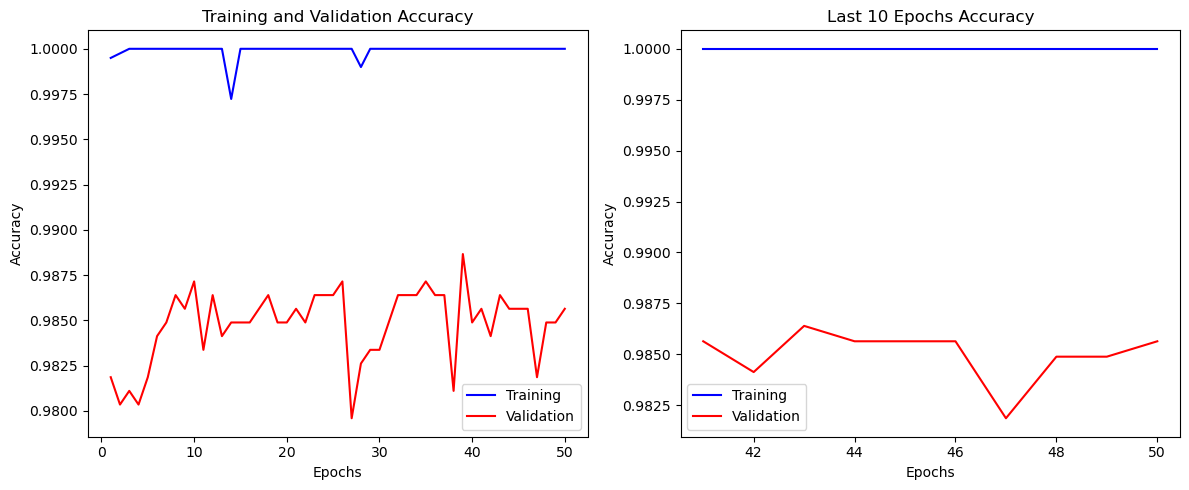

In [75]:
def plot_metrics(train_metric, val_metric, metric_name):
    
    epochs = range(1, len(train_metric) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_metric, 'b', label='Training')
    plt.plot(epochs, val_metric, 'r', label='Validation')
    plt.title('Training and Validation ' + metric_name)
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs[-10:], train_metric[-10:], 'b', label='Training')
    plt.plot(epochs[-10:], val_metric[-10:], 'r', label='Validation')
    plt.title('Last 10 Epochs ' + metric_name)
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()

    plt.tight_layout()
    plt.show()

hist = []
for fold, history in enumerate(all_histories):
        hist = history.history

plot_metrics(hist['loss'], hist['val_loss'], 'Loss')
plot_metrics(hist['accuracy'], hist['val_accuracy'], 'Accuracy')


### OBSERVATIONS

The Keras model training has produced impressive results, demonstrating a Test Loss of 0.181, Test Accuracy of 97.13%, Test Precision of 97.05%, and Test Recall (Keras metric) of 97.20%. However, a closer examination of the training dynamics reveals signs of overfitting, as indicated by the decreasing accuracy and increasing loss after epoch 49. To mitigate overfitting, the next experiment will involve reducing the number of epochs to 45.

Additionally, a dropout layer with a rate of 0.1 has been added to introduce regularization. For the subsequent experiment, the dropout rate will be slightly increased to 0.3 to assess its impact on model performance. Furthermore, to explore the effect of model architecture, an additional hidden layer will be introduced.

The next steps involve conducting individual experiments by varying these parameters to analyze their effects on the model's performance. By systematically modifying the architecture and regularization techniques, we aim to achieve a balance between model complexity and generalization performance. This iterative process will provide valuable insights into optimizing the model for improved predictive accuracy and robustness.

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 256)               345088    
                                                                 
 dense_15 (Dense)            (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 128)               16512     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 45)                5805      
                                                                 
Total params: 400301 (1.53 MB)
Trainable params: 40030

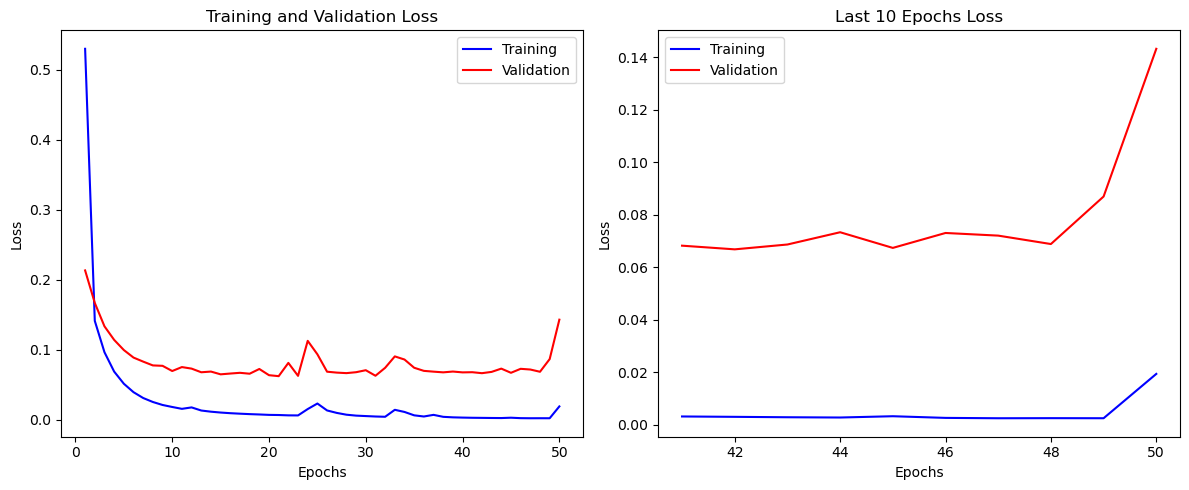

Fold 1 history:
Fold 2 history:
Fold 3 history:
Fold 4 history:


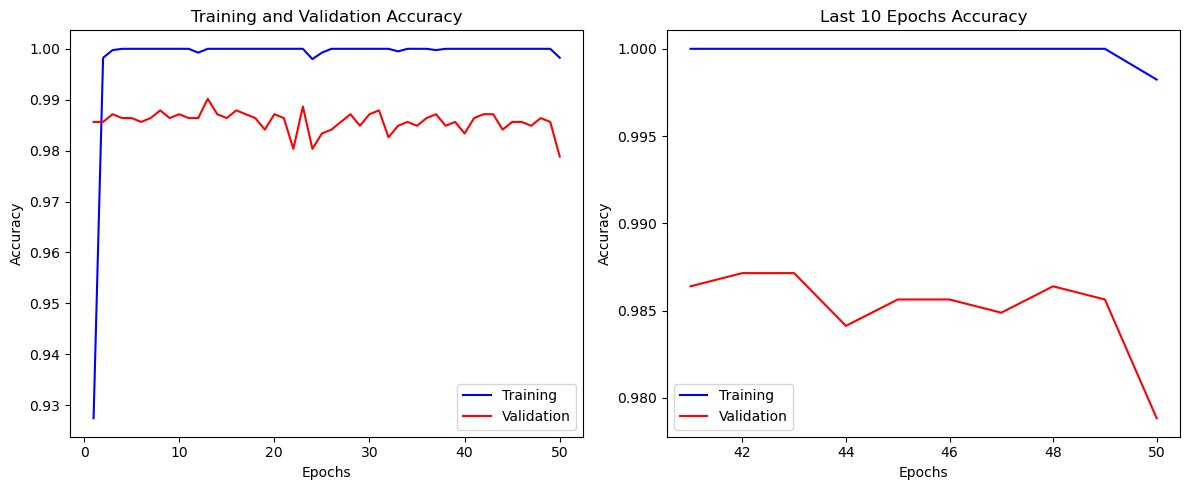

42/42 [==============================] - 0s 3ms/step - loss: 0.0576 - accuracy: 0.9849 - recall_4: 0.9811 - precision_4: 0.9901
Test Loss: 0.057574592530727386
Test Accuracy: 0.9848828315734863
Test Recall (Keras metric): 0.9811035394668579
Test Precision (Keras metric): 0.9900839328765869


In [69]:
model2 = create_model(num_layers=3)
model2.summary()

all_histories2 = k_fold_validation_training(model2, X_partial_train, y_partial_train, num_epochs=45, batch_size=32, K=4)


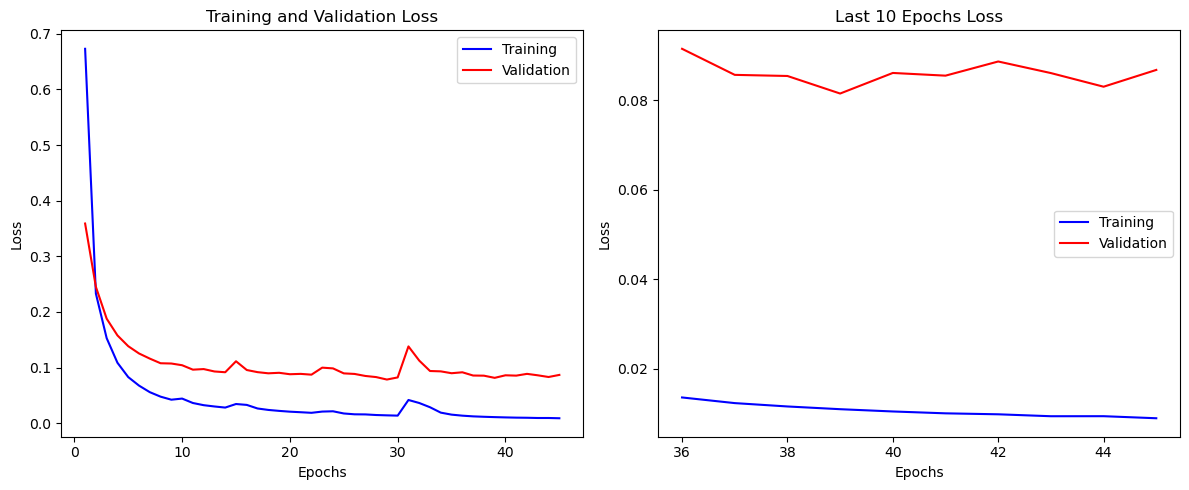

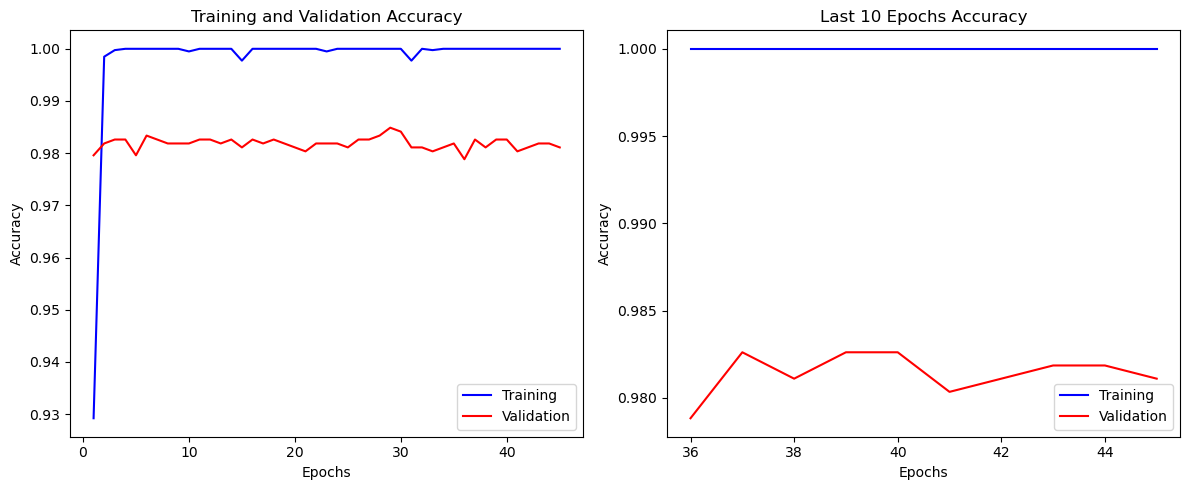

42/42 [==============================] - 0s 4ms/step - loss: 0.0576 - accuracy: 0.9849 - recall_4: 0.9811 - precision_4: 0.9901
Test Loss: 0.057574592530727386
Test Accuracy: 0.9848828315734863
Test Recall (Keras metric): 0.9811035394668579
Test Precision (Keras metric): 0.9900839328765869


In [77]:
hist2 = []
for fold, history in enumerate(all_histories2):
        hist2 = history.history
        

plot_metrics(hist2['loss'], hist2['val_loss'], 'Loss')
plot_metrics(hist2['accuracy'], hist2['val_accuracy'], 'Accuracy')

loss2, accuracy2, recall2,precision2 = model2.evaluate(X_validation, y_validation)

print("Test Loss:", loss2)
print("Test Accuracy:", accuracy2)
print("Test Recall (Keras metric):", recall2)
print("Test Precision (Keras metric):", precision2)

# EMBEDDING LAYERS

After experimenting with adjustments to the dropout rate and network depth without significant improvements in model performance, the next step is to explore embedding layers as an alternative approach. Embedding layers are particularly suited for handling text data, which is the nature of our features.

In this experiment, I employed an embedding layer with an embedding dimension of 50. The model architecture involves the following steps:

1. **Embedding Layer**: An embedding layer is added to the sequential model, with parameters configured for input vocabulary size (`vocab_size_embedding`), output embedding dimension (`embedding_dim`), and input sequence length (`max_len`). This layer converts input text data into dense vector representations, capturing semantic relationships between words.

2. **GlobalMaxPooling1D Layer**: This layer is added to reduce the dimensionality of the output from the embedding layer, extracting the maximum value along the temporal dimension. This step aggregates information from the entire input sequence, preserving the most relevant features.

3. **Dense Layers**: Following the pooling layer, two dense layers are added. The first dense layer consists of 128 units and uses the ReLU activation function to introduce non-linearity and capture complex patterns in the data. The final dense layer produces the output predictions, with the softmax activation function for multi-class classification.

4. **Model Compilation**: The model is compiled with the Adam optimizer, categorical cross-entropy loss function for multi-class classification, and metrics including accuracy, recall, and precision.

5. **Model Training**: To evaluate the performance of the embedding layer approach, k-fold cross-validation training is performed using the `k_fold_validation_training` function. This function trains the model on the training data (`X_partial_train_emb`, `y_partial_train_emb`) with specified hyperparameters (`num_epochs=45`, `batch_size=32`) and K-fold cross-validation (`K=4`).

By leveraging embedding layers, the model aims to learn meaningful representations of the input text data, capturing semantic similarities and improving classification performance. The subsequent analysis of training histories and evaluation metrics will provide insights into the effectiveness of this approach compared to previous experiments.

In [102]:
loss2, accuracy2, recall2,precision2 = model2.evaluate(X_validation, y_validation)

print("Test Loss:", loss2)
print("Test Accuracy:", accuracy2)
print("Test Recall (Keras metric):", recall2)
print("Test Precision (Keras metric):", precision2)

49/49 [==============================] - 0s 3ms/step - loss: 0.7613 - accuracy: 0.8700 - recall_1: 0.8376 - precision_1: 0.9457
Test Loss: 0.7613242864608765
Test Accuracy: 0.8700454831123352
Test Recall (Keras metric): 0.8375568389892578
Test Precision (Keras metric): 0.9457079768180847


In [79]:
embedding_dim = 50

model3 = Sequential()
model3.add(layers.Embedding(input_dim=vocab_size_embedding, 
                           output_dim=embedding_dim, 
                           input_length=max_len))
model3.add(layers.GlobalMaxPool1D())
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dense(num_classes, activation='softmax'))
model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
model3.summary()



all_histories3 = k_fold_validation_training(model3, X_partial_train_emb, y_partial_train_emb, num_epochs=45, batch_size=32, K=4)





Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 50)           67350     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 50)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_20 (Dense)            (None, 128)               6528      
                                                                 
 dense_21 (Dense)            (None, 45)                5805      
                                                                 
Total params: 79683 (311.26 KB)
Trainable params: 79683 (311.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Processing fold
Processing fold
Processing fold
Processing fold


In [80]:
loss3, accuracy3, precision3, recall3 = model3.evaluate(X_validation_emb, y_validation_emb)

print("Test Loss:", loss3)
print("Test Accuracy:", accuracy3)
print("Test Precision:", precision3)
print("Test Recall (Keras metric):", recall3)

42/42 [==============================] - 0s 2ms/step - loss: 0.4098 - accuracy: 0.9199 - recall_6: 0.9169 - precision_6: 0.9316
Test Loss: 0.4097675383090973
Test Accuracy: 0.9198790788650513
Test Precision: 0.9168556332588196
Test Recall (Keras metric): 0.9316436052322388


### OBSERVATIONS

After reviewing the model's performance, despite achieving relatively good results, there's still room for improvement. In the next experiment, I plan to enhance the model's capabilities by incorporating additional regularization techniques and broadening the network.

1. **Regularization**: To address potential overfitting and further enhance generalization, I will introduce regularization techniques such as dropout and L2 regularization. Dropout randomly deactivates a fraction of neurons during training, preventing the network from becoming overly reliant on specific connections. Additionally, L2 regularization imposes a penalty on the magnitude of weights, encouraging simpler models and reducing the risk of overfitting.

2. **Network Broadening**: By doubling the number of input neurons to 256, I aim to increase the model's capacity to capture complex patterns and relationships in the data. A wider network can potentially extract more informative features from the input, leading to improved performance in classification tasks.

By implementing these adjustments, I anticipate the model to achieve better generalization and performance metrics. The subsequent training and evaluation of the enhanced model will provide insights into the effectiveness of these modifications in further optimizing the classification performance.

In [81]:
embedding_dim = 50

model4 = Sequential()
model4.add(layers.Embedding(input_dim=vocab_size_embedding, 
                           output_dim=embedding_dim, 
                           input_length=max_len))
model4.add(layers.GlobalMaxPool1D())
model4.add(layers.Dense(256, activation='relu',  kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model4.add(layers.Dense(num_classes, activation='softmax'))
model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
model4.summary()

all_histories4 = k_fold_validation_training(model4, X_partial_train_emb, y_partial_train_emb, num_epochs=45, batch_size=32, K=4)




Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 150, 50)           67350     
                                                                 
 global_max_pooling1d_2 (Gl  (None, 50)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_22 (Dense)            (None, 256)               13056     
                                                                 
 dense_23 (Dense)            (None, 45)                11565     
                                                                 
Total params: 91971 (359.26 KB)
Trainable params: 91971 (359.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Processing fold
Processing fold
Processing fold
Processing fold


In [82]:
loss4, accuracy4, precision4, recall4 = model4.evaluate(X_validation_emb, y_validation_emb)

print("Test Loss:", loss4)
print("Test Accuracy:", accuracy4)
print("Test Precision:", precision4)
print("Test Recall (Keras metric):", recall4)

42/42 [==============================] - 0s 2ms/step - loss: 0.3380 - accuracy: 0.9259 - recall_7: 0.9138 - precision_7: 0.9557
Test Loss: 0.33803173899650574
Test Accuracy: 0.9259259104728699
Test Precision: 0.9138321876525879
Test Recall (Keras metric): 0.955731213092804


The outcomes obtained after broadening the network and incorporating regularization techniques yielded the following metrics: 
- Loss: 0.3380
- Test Accuracy: 0.9259
- Test Precision: 0.9138
- Test Recall (Keras metric): 0.9557.

Upon analysis, it's evident that while there was an improvement in performance, it was relatively subtle compared to the computational resources required for doubling the neurons to 256. Striking a balance between optimizing model performance and managing computational costs is crucial. The next experiment aims to achieve this equilibrium by implementing adjustments that consider both effectiveness and efficiency.


### Enhancing Model Efficiency and Performance

In the pursuit of finding the optimal balance between computational efficiency and model performance, I went further to refine the neural network architecture for improved classification accuracy.
The primary goal of this experiment is to enhance the model's performance while considering computational efficiency. To achieve this, I will make modifications to the neural network architecture and regularization techniques.

#### Changes Implemented:
1. **Utilizing Pre-trained Word Embeddings**: To leverage existing linguistic knowledge and reduce the computational burden of training, I will incorporate pre-trained word embeddings obtained from the GloVe model. By initializing the embedding layer with pre-trained weights, the model can capture semantic relationships between words effectively.

2. **Adjusting Regularization**: After the previous experiment where i noticed the increse in perfomance as a result of regularazation, for this experiemnt i also plan on using  L2 regularization with a lambda parameter of 0.001 to mitigate overfitting while maintaining model simplicity. This regularization technique penalizes the magnitude of weights, promoting a more generalized model.

3. **Fine-tuning Embedding Layer**: While utilizing pre-trained embeddings, I will allow the embedding layer to be trainable during model training. This adjustment enables the model to adapt the embeddings to the specific task at hand, further enhancing its representational capacity.

#### Rationale:
- **Pre-trained Embeddings**: By leveraging pre-trained embeddings, the model can benefit from the extensive linguistic knowledge encoded in the GloVe embeddings, leading to better semantic representation of input text and potentially improving classification accuracy.
  
- **L2 Regularization**: Introducing L2 regularization helps prevent the neural network from becoming overly complex, thereby reducing the risk of overfitting. This regularization technique encourages the model to focus on essential features and generalize better to unseen data.
  
- **Trainable Embedding Layer**: Allowing the embedding layer to be trainable enables the model to fine-tune the embeddings to better suit the specific classification task. This adaptability ensures that the embeddings capture task-specific nuances, leading to improved performance.



In [88]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding = 'utf-8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

embedding_dim = 50
embedding_matrix = create_embedding_matrix('trainingData/glove.6B/glove.6B.50d.txt', tokenizer_embedding.word_index, embedding_dim )
print("Vocabulary size:", len(tokenizer_embedding.word_index)+1)
#94% of the vocabulary is covered by the pretrained model, which is a good coverage of my vocabulary.
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size_embedding


model5 = Sequential()
model5.add(layers.Embedding(vocab_size_embedding, 
                           embedding_dim, 
                           input_length=max_len,
                          trainable= True))
model5.add(layers.GlobalMaxPool1D())
model5.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model5.add(layers.Dense(128, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model5.add(layers.Dense(num_classes, activation='softmax'))
model5.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
model5.summary()

all_histories5 = k_fold_validation_training(model5, X_partial_train_emb, y_partial_train_emb, num_epochs=45, batch_size=64, K=4)


Vocabulary size: 1347
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 150, 50)           67350     
                                                                 
 global_max_pooling1d_5 (Gl  (None, 50)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_29 (Dense)            (None, 256)               13056     
                                                                 
 dense_30 (Dense)            (None, 128)               32896     
                                                                 
 dense_31 (Dense)            (None, 45)                5805      
                                                                 
Total params: 119107 (465.26 KB)
Trainable params: 119107 (465.26 KB)
Non-trainable params: 0 (0.

In [89]:
loss5, accuracy5, precision5, recall5 = model5.evaluate(X_validation_emb, y_validation_emb)

# Print the evaluation results
print("Test Loss:", loss5)
print("Test Accuracy:", accuracy5)
print("Test Precision:", precision5)
print("Test Recall (Keras metric):", recall5)

42/42 [==============================] - 0s 2ms/step - loss: 0.4250 - accuracy: 0.9161 - recall_10: 0.9010 - precision_10: 0.9582
Test Loss: 0.42495661973953247
Test Accuracy: 0.9160997867584229
Test Precision: 0.9009826183319092
Test Recall (Keras metric): 0.9581993818283081


In [118]:

test_accuracy_exp3=0.6281050390347764 
test_recall_exp3= 0.6281050390347764
test_loss_exp3= 3.666532154613858
test_precision3= 0.7848405798014125

test_accuracy_exp2=  0.7075940383250532
test_recall_exp2= 0.7075940383250532
test_loss_exp2= 3.944167187596317
test_precision2= 0.778873685797452

test_accuracy_exp1= 0.198722498225692
test_recall_exp1= 0.198722498225692
test_loss_exp1= 7.60205933075892
test_precision1= 0.7287293519252981

test_accuracy_baseline=0.016323633782824698
test_loss_baseline=6.112595441149571
test_recall_baseline= 0.016323633782824698
test_precision_baseline= 1.0

models = ['Baseline', 'Experiment 1', 'Experiment2', 'Experiment3', 'Experiment4','Keras Model 1', 'Keras Model 2', 'Embedding', 'Embedding2','Embedding GloVE']
accuracies = [test_accuracy_baseline, test_accuracy_exp1, test_accuracy_exp2, test_accuracy_exp3,test_accuracy, accuracy, accuracy2, accuracy3, accuracy4, accuracy5]
recalls= [test_recall_baseline, test_recall_exp1, test_recall_exp2, test_recall_exp3, test_recall, recall, recall2,recall3, recall4, recall5]
precisions= [test_precision_baseline,test_precision1,test_precision2,test_precision3, test_precision, precision,precision2,precision3, precision4, precision5]
losses= [test_loss_baseline, test_loss_exp1, test_loss_exp2, test_loss_exp3, test_loss, loss,loss2, loss3, loss4, loss5]


data = {
    'Model': models,
    'Accuracy': accuracies,
    'Recall': recalls,
    'Precision': precisions,
    'Loss': losses
}
df_results = pd.DataFrame(data)

df_results.head(10)



,Model,Accuracy,Recall,Precision,Loss
0,Baseline,0.016324,0.016324,1.000000,6.112595
1,Experiment 1,0.198722,0.198722,0.728729,7.602059
2,Experiment2,0.707594,0.707594,0.778874,3.944167
3,Experiment3,0.628105,0.628105,0.784841,3.666532
4,Experiment4,0.862898,0.862898,0.872054,22.413518
5,Keras Model 1,0.862898,0.834308,0.956069,0.687153
6,Keras Model 2,0.870045,0.837557,0.945708,0.761324
7,Embedding,0.923327,0.932237,0.920728,0.412565
8,Embedding2,0.936972,0.952603,0.927225,0.266566
9,Embedding GloVE,0.927875,0.939894,0.924626,0.456032


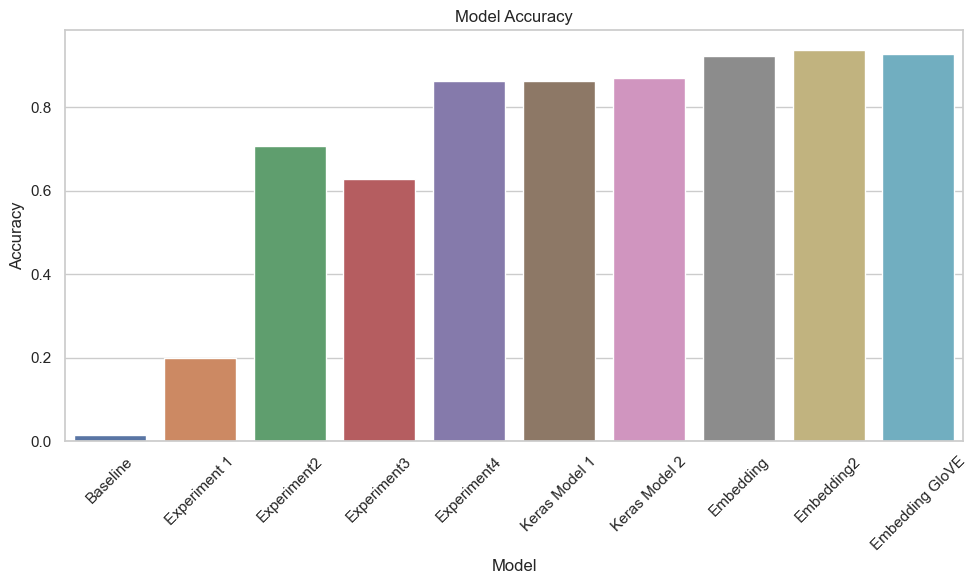

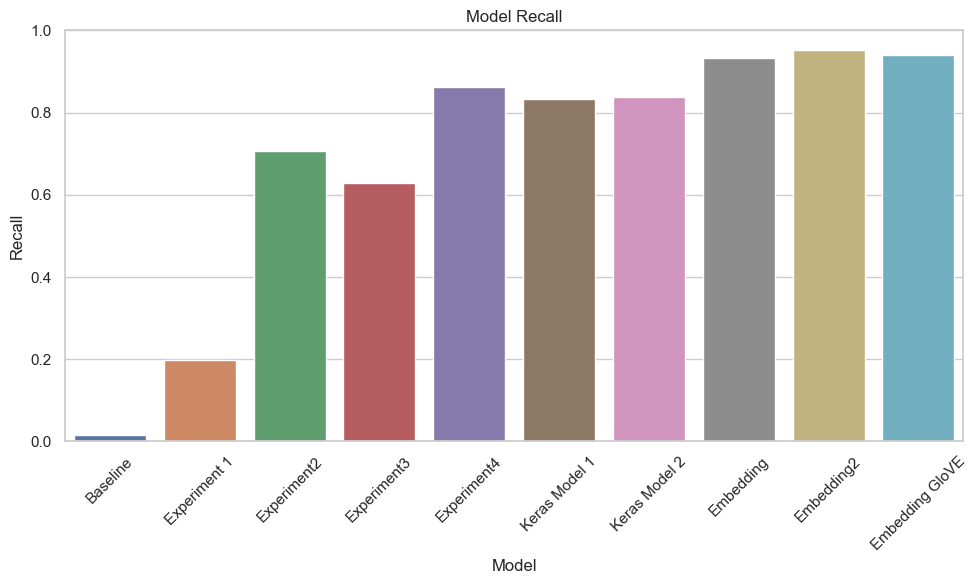

In [120]:
sns.set(style="whitegrid")

# Plot for Accuracy
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=df_results)
plt.title('Model Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot for Recall
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Recall', data=df_results)
plt.title('Model Recall')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



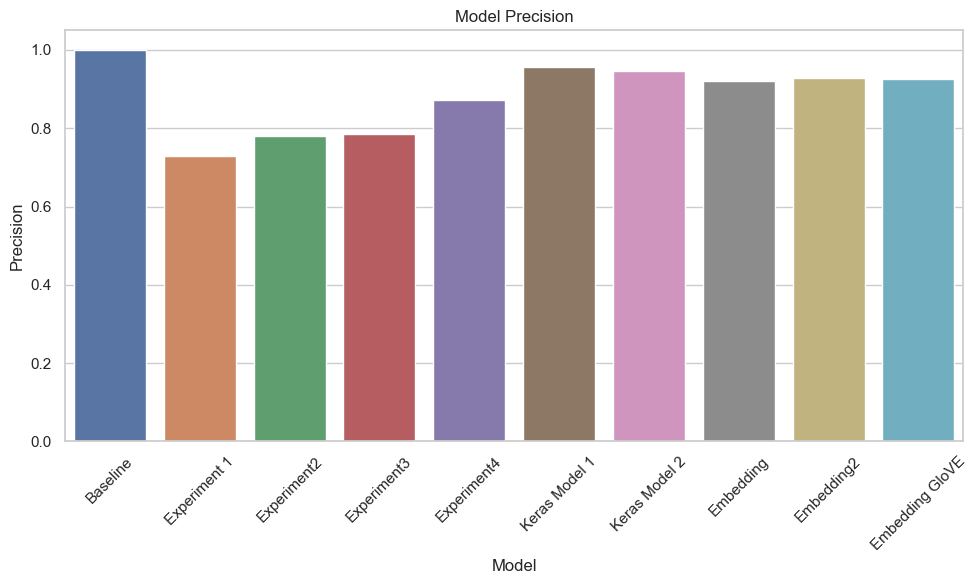

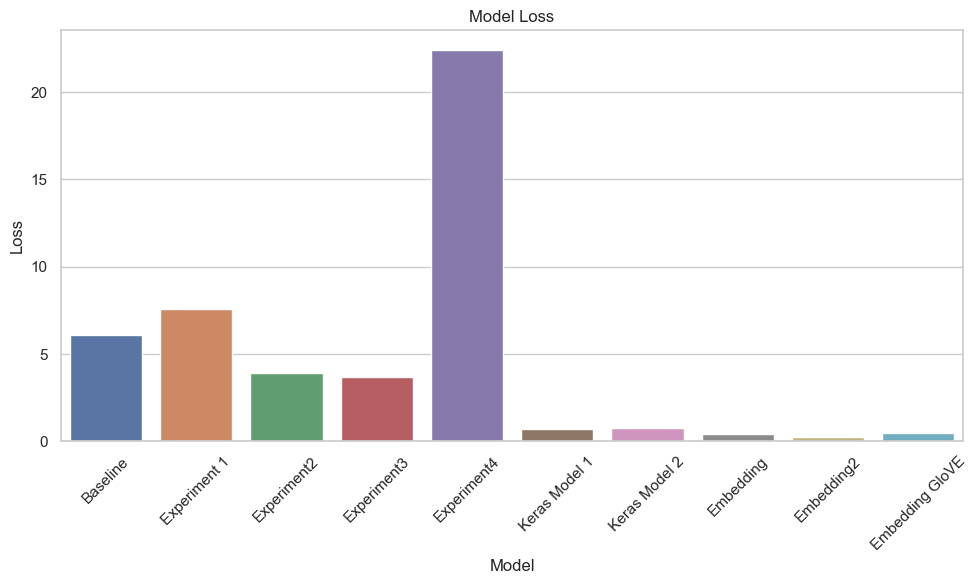

In [121]:
# Plot for Precision
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Precision', data=df_results)
plt.title('Model Precision')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot for Loss
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Loss', data=df_results)
plt.title('Model Loss')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# USER INTERPHASE

In [21]:
import json
import pandas as pd

with open('trainingData/mapping.json', 'r') as file:
    data = json.load(file)

mapping = pd.DataFrame(list(data.items()), columns=['Disease', 'Label'])

mapping.head()


disease_data = pd.read_csv('Disease_data/disease_data.csv')
disease_data.head()

,Disease,Medicine_Name,Risk_Factors,Precautions_x,Descriptions,Symptoms
0,adhd,['no medicine available (consult doctor)'],"['Exposure to environmental toxins, family his...","['protein-rich breakfast, walk to school if po...",No Description found for this disease,No Symptoms found for this disease
1,acne,['Isoniazid (antibiotics)'],"['Being teenager, Hormonal changes, Friction o...","['Bath twice, avoid fatty spicy food, drink pl...","Acne vulgaris is the formation of comedones, p...","['skin_rash', 'pus_filled_pimples', 'blackhead..."
2,adenomyosis,['no medicine available (consult doctor)'],"['Prior uterine surgery, such as a C-section o...",['No precaution'],No Description found for this disease,No Symptoms found for this disease
3,alzheimer's,['cholinesterase inhibitors'],"['Lack of exercise, Obesity, Smoking, High BP,...","['Stopping smoking, keeping alcohol to a minim...",No Description found for this disease,No Symptoms found for this disease
4,amnesia,['no medicine available (consult doctor)'],"['Brain surgery, head injury or trauma, Stroke...","['Avoid heavy use of alcohol, drugs, Stay ment...",No Description found for this disease,No Symptoms found for this disease


In [43]:
import tkinter as tk
import csv
from tkinter import messagebox, StringVar, OptionMenu, Text, Entry, Button, Label, Toplevel

def predict():
    selected_model = model_var.get()
    selected_symptoms = [symptom_var.get() for symptom_var in symptom_vars]
    typed_symptoms = userinput.get()

    if all(symptom == "None" for symptom in selected_symptoms) and typed_symptoms == "None":
        messagebox.showerror("Error", "Please select or type at least one symptom.")
        return
    
    if selected_model == "Custom_Model":
        prediction_result, confidence = Custom_Model(selected_symptoms, typed_symptoms)
    elif selected_model == "Keras_Model":
        prediction_result, confidence = Keras_Model(selected_symptoms, typed_symptoms)
    else:
        prediction_result = "Please select a model"
        confidence = 0  
    threshold = 0.7  
    if confidence < threshold:
        messagebox.showerror("Low Confidence", "The model's confidence in the prediction is low. Please provide more meaningful symptoms.")
        return
    
    result_text.delete('1.0', tk.END) 
    result_text.insert(tk.END, prediction_result)

def reset_inputs():
    for var in symptom_vars:
        var.set("None")
    userinput.set("")
    result_text.delete('1.0', tk.END)

def Keras_Model(symptoms , userinput):
    input_symptoms = " "
    if all(symptom == "None" for symptom in symptoms) and userinput == "None":
        messagebox.showerror("Error", "Please select or type at least one symptom.")
        return
    else:
        input_symptoms = " ".join(symptom for symptom in symptoms if symptom != "None")
        if userinput != " None":
            input_symptoms += ", " + userinput
        
        print("User entered the following symptoms: ", input_symptoms)
        text = preprocess_text(input_symptoms)
    
        # Tokenize and pad the sequence
        sequence = tokenizer.texts_to_sequences([text])
        feature = pad_sequences(sequence, maxlen=max_len)

        # Make prediction
        prediction = model4.predict(feature)
        confidence = np.max(prediction)
       
        #labels_encoded_inverse= encoder_resample.inverse_transform(prediction)
        #labels_decoded = labels_encoded_inverse.reshape(-1)
        labels_decoded = prediction + (prediction // num_classes) * (num_classes - 1)

        # Verify the result
        print(labels_decode)
      
        # Display the predicted disease
        predicted_disease = labels_decoded[0]
        for index, row in mapping.iterrows():
            # Check if the predicted label matches the label in the mapping DataFrame
            if predicted_disease== row['Label']:
                # If there is a match, assign the corresponding disease to predicted_disease
                predicted_disease = row['Disease']
                break
        print( f"From the following symptoms, {input_symptoms} its likely that you have : {predicted_disease}, code: {labels_decoded}")
        return predicted_disease, confidence 


# Prediction with my own custom model
def Custom_Model(symptoms, userinput):
    
    input_symptoms = " "
        
    if all(symptom == "None" for symptom in symptoms) and userinput == "None":
        return "OPPS!!", "ENTER  SYMPTOMS PLEASE"
    else:
        input_symptoms = " ".join(symptom for symptom in symptoms if symptom != "None")
        if userinput != " None":
            input_symptoms += ", " + userinput
        
        print("User entered the following symptoms: ", input_symptoms)
        text = preprocess_text(input_symptoms)
    
        # Tokenize and pad the sequence
        sequence = tokenizer.texts_to_sequences([text])
        feature = pad_sequences(sequence, maxlen=max_len)

        # Make prediction
        prediction = model_predict(feature, trained_parameters_exp4)
        confidence= np.max(prediction)
      
        labels_encoded_inverse= encoder_resample.inverse_transform(prediction)
        labels_decoded = labels_encoded_inverse.reshape(-1)
      
        # Display the predicted disease
        predicted_disease = labels_decoded[0]
        for index, row in mapping.iterrows():
            # Check if the predicted label matches the label in the mapping DataFrame
            if predicted_disease== row['Label']:
                # If there is a match, assign the corresponding disease to predicted_disease
                predicted_disease = row['Disease']
                break
        print( f"From the input symptoms its likely that you have : {predicted_disease}, code: {labels_decoded}")
        return  predicted_disease, confidence

def provide_feedback():
    feedback_window = Toplevel(root)
    feedback_window.title("Provide Feedback")

    tk.Label(feedback_window, text="Predicted Disease:").pack()
    predicted_disease_entry = tk.Entry(feedback_window)
    predicted_disease_entry.pack()
    
    tk.Label(feedback_window, text="Actual Disease (if known):").pack()
    actual_disease_entry = tk.Entry(feedback_window)
    actual_disease_entry.pack()
    
    tk.Label(feedback_window, text="Confidence Level (%):").pack()
    confidence_entry = tk.Entry(feedback_window)
    confidence_entry.pack()
    
    tk.Label(feedback_window, text="Comments:").pack()
    comments_entry = tk.Text(feedback_window, height=5)
    comments_entry.pack()
    
    # Submit button
    submit_button = Button(feedback_window, text="Submit Feedback", command=lambda: submit_feedback(feedback_window, predicted_disease_entry.get(), actual_disease_entry.get(), confidence_entry.get(), comments_entry.get(1.0, tk.END)))
    submit_button.pack()        
    
def submit_feedback(feedback_window, predicted_disease, actual_disease, confidence_level, comments):
    # Define the file path where the feedback will be saved
    csv_file = 'Feedback/feedback.csv'
    
    feedback_data = [predicted_disease, actual_disease, confidence_level, comments]

    try:
        # Open the CSV file in append mode and write the feedback data
        with open(csv_file, 'a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(feedback_data)
        
        # Show a message box to inform the user that the feedback has been submitted
        messagebox.showinfo("Feedback Submitted", "Thank you for your feedback!")
    
    except Exception as e:
        # If an error occurs while saving the feedback, show an error message
        messagebox.showerror("Error", f"An error occurred while saving feedback: {e}")

    # Close the feedback window
    feedback_window.destroy()

def update_user_input(event=None):
    content = user_input_text.get("1.0", "end-1c")  
    userinput.set(content)  
    
def update_symptom_color(*args):
    for i, var in enumerate(symptom_vars):
        symptom = var.get()
        if symptom != "None":
            symptom_labels[i].config(bg="lightgreen")  
        else:
            symptom_labels[i].config(bg=bg_color) 

def more_info():
    predicted_disease = result_text.get("1.0", tk.END).strip()
    
    if predicted_disease:
        matching_disease = disease_data[disease_data['Disease'] == predicted_disease]
        if not matching_disease.empty:
            info_window = Toplevel(root)
            info_window.title(f"Information for {predicted_disease}")

            # Display information about the predicted disease
            tk.Label(info_window, text=f"Disease: {predicted_disease}", font=("Helvetica", 18), bg=bg_color, fg="blue").pack()
            tk.Label(info_window, text=f"Medicine Name: {matching_disease['Medicine_Name'].iloc[0]}", font=("Helvetica", 12), bg=bg_color).pack()
            tk.Label(info_window, text=f"Risk Factors: {matching_disease['Risk_Factors'].iloc[0]}", bg=bg_color, fg="black", font=("Helvetica", 12)).pack()
            tk.Label(info_window, text=f"Precautions: {matching_disease['Precautions_x'].iloc[0]}",bg=bg_color, fg="black", font=("Helvetica", 12)).pack()
            tk.Label(info_window, text=f"Symptoms: {matching_disease['Symptoms'].iloc[0]}",bg=bg_color, fg="black", font=("Helvetica", 12)).pack()
        else:
            messagebox.showinfo("Information", f"No information available for {predicted_disease}.")
    else:
        messagebox.showinfo("Information", "No prediction result available.")

root = tk.Tk()
root.title("Disease Prediction From Symptoms")

bg_color = "#f0f0f0"
font_style = ("Helvetica", 12)

main_frame = tk.Frame(root, bg=bg_color)
main_frame.pack(padx=20, pady=20)

header_label = tk.Label(main_frame, text="Disease Prediction From Symptoms", font=("Helvetica", 18), bg=bg_color)
header_label.grid(row=0, column=0, columnspan=4, pady=10)

# Symptoms Section
symptoms_label = tk.Label(main_frame, text="Choose symptoms or type your symptoms:", font=font_style, bg=bg_color)
symptoms_label.grid(row=1, column=0, columnspan=3, pady=(0, 5))

symptoms_options = ["None", "Fever", "weight_loss", "vomiting", "dark_urine", "abdominal_pain", "yellowish_skin", "fatigue"]
symptom_vars = [StringVar() for _ in range(7)]
for var in symptom_vars:
    var.set("None")
symptom_labels = []
for i in range(7):
    symptom_label = tk.Label(main_frame, text=f"Symptom {i+1}:", font=font_style, bg=bg_color)
    symptom_label.grid(row=i+2, column=0, pady=5, padx=(10, 5))
    symptom_optionmenu = OptionMenu(main_frame, symptom_vars[i], *symptoms_options)
    symptom_optionmenu.grid(row=i+2, column=1, pady=5, padx=(5, 10), sticky="ew")
    symptom_labels.append(symptom_label)

for var in symptom_vars:
    var.trace("w", update_symptom_color)

# User Input
tk.Label(main_frame, text="Input Symptoms:", font=font_style, bg=bg_color).grid(row=9, column=0, pady=5, padx=(10, 5))
userinput = StringVar()
userinput.set("None")
user_input_text=Text(main_frame,height=4, wrap=tk.WORD)
user_input_text.grid(row=9, column=1, pady=(0, 10), padx=10, sticky="ew")
user_input_text.bind("<KeyRelease>", update_user_input)

# Model Selection
model_label = tk.Label(main_frame, text="Select prediction model:", font=font_style, bg=bg_color)
model_label.grid(row=10, column=0, columnspan=2, pady=(10, 5))

model_options = ["Keras_Model", "Custom_Model"]
model_var = StringVar()
model_var.set(model_options[0])  # Set default model
OptionMenu(main_frame, model_var, *model_options).grid(row=11, column=0, columnspan=2, padx=10, pady=5, sticky="ew")

# Predict Button
predict_button = tk.Button(main_frame, text="Predict", command=predict, bg="#4CAF50", fg="white", font=font_style)
predict_button.grid(row=12, column=0, columnspan=2, pady=(10, 0), padx=10, sticky="ew")

# Reset Button
reset_button = tk.Button(main_frame, text="Reset", command=reset_inputs, bg="#FF5733", fg="white", font=font_style)
reset_button.grid(row=12, column=2, columnspan=2, pady=(10, 0), padx=10, sticky="ew")

# Result Section
result_label = tk.Label(main_frame, text="Prediction Result:", font=font_style, bg=bg_color)
result_label.grid(row=13, column=0, columnspan=2, pady=(20, 5))

result_text = Text(main_frame, height=5, width=50)
result_text.grid(row=14, column=0, columnspan=2, padx=10, sticky="ew")

# Feedback Button
feedback_button = Button(main_frame, text="Provide Feedback", command=provide_feedback, bg="#4CAF50", fg="white", font=("Helvetica", 12))
feedback_button.grid(row=15, column=0, columnspan=2, pady=(10, 0), padx=10, sticky="ew")

# More Info Button
more_info_button = Button(main_frame, text="Disease Information", command=more_info, bg="#008CBA", fg="white", font=font_style)
more_info_button.grid(row=15, column=2, columnspan=2, pady=(10, 0), padx=10, sticky="ew")

root.mainloop()
